## <font color='blue'> EconophysiX Internship - Felipe Moret \& Michele Vodret - Microfounding Propagator Models </font>

## <font color='red'> Studiyng A Rational Noise Trader with Full Utility Function (Discounting Factor)  - The case with 3 seeds </font>

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
from scipy import linalg
from math import *
from numba import njit
import math
import seaborn as sns
from matplotlib import colors
import pandas as pd

#import sys
#if "\your\path\to\xelatex" not in sys.path:
#    print('adding path') # I just add this to know if the path was present or not.
#    sys.path.append("\your\path\to\xelatex")

def delta(i):
    if i == 0:
        return 1
    else:
        return 0
    
def delta_vector(n):
    vec = np.zeros(n)
    vec[0] = 1
    return vec

COLOR = (0, 0, 0.1)

def color_conv(color_range):
    return (COLOR[0] + color_range, COLOR[1], COLOR[2])

## Auxilliary functions for common ACFs

**Markovian Process ACF**

In [2]:
def return_Markovian_ACF(C_0, tau, T):
    ACF = np.zeros((T,T))
    alpha = np.exp(-1/tau)
    for i in range(0,T):
        for j in range(0,T):
            ACF[i,j] = C_0*alpha**np.abs(i-j)
    return ACF

In [3]:
def make_ACF_IT_invertible(ACF_IT):
    
    T = ACF_IT.shape[0]
    
    for i in range(1,T):
        ACF_IT[i,-1] = ACF_IT[i-1,-2]
        
    ACF_IT[-1,:] = ACF_IT[:,-1]
    
    return ACF_IT

## Metric for convergence - Cumulated error - $err$

In [4]:
def err_G(G1, G2):
    
    T = len(G1)
    
    relative_error = 0
    G1_sum = 0
    
    
    for i in range(0,T):
        relative_error += relative_error + np.abs(G1[i]/G1[0] - G2[i]/G2[0])
        G1_sum += G1_sum + np.abs(G1[i]/G1[0])
                
    return relative_error/G1_sum

In [5]:
def err_ACF(ACF1, ACF2):
    
    T = len(ACF1)
    
    relative_error = 0
    ACF1_sum = 0
    
    
    for i in range(1,T):
        relative_error += relative_error + np.abs((ACF1[i]/ACF1[1]) - (ACF2[i]/ACF2[1]))
        ACF1_sum += ACF1_sum + np.abs(ACF1[i]/ACF1[1])
                
    return relative_error/ACF1_sum

## Coding the forecast matrix

In [6]:
#@njit
def optimized_matrix_inverse(matrix):
    return np.linalg.inv(matrix)

In [7]:
def Mforecast(tipo, process, param, t0, T, C_fixed):

        tau_mu = param[0]
        tau_NT = param[1]
        if tipo == "mark":
            if process == "MU":
                alpha_appo = np.exp(-1/param[0])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
                flag = 0
            if process == "NT":
                alpha_appo = np.exp(-1/param[1])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
                flag = 0
        if tipo == "osc":
            if process == "MU":
                alpha_mu = np.exp(-1/param[0])
                tau1_mu = param[1]
                C_appo = np.fromfunction(lambda i,j : alpha_mu**np.abs(i-j)*np.sin((i-j)/tau1_mu+np.pi/2), (T,T), dtype = float)
                flag = 0
            if process == "NT":
                alpha_NT = np.exp(-1/param[2])
                tau1_NT = param[3]
                C_appo = np.fromfunction(lambda i,j : alpha_NT**np.abs(i-j)*np.sin((i-j)/(tau1_NT)+np.pi/2), (T,T), dtype = float)
                flag = 0
                     
        if tipo == "id":
            C_appo = np.identity(T)
            flag = 0
        
        if tipo == "pl":
            if process == "MU":
                tau = param[0]
                gamma = param[1]
                C_appo = (np.fromfunction(lambda i, j: np.power( 1+np.absolute(i-j)/tau,-gamma), (T,T), dtype=float))
                flag = 0
            if process == "NT":
                tau = param[2]
                gamma = param[3]
                C_appo = (np.fromfunction(lambda i, j: np.power( 1+np.absolute(i-j)/tau,-gamma), (T,T), dtype=float))
                flag = 0
        
        if tipo == "fixed":
                C_appo = C_fixed
                flag = 1
            
        g = np.zeros((T-t0,t0))
        for J in range (t0+1,T+1):
            
            # In the case of a fixed ACF given, this part of the code augments the correlation matrix at each 
            # iteration, in view of evaluating the forecasts
            if(flag):
                C_last = C_appo
                C_appo = np.zeros((J,J))
                J_last = C_last.shape[0]
                for i in range (0,J_last):
                    for j in range(0,J_last):
                        C_appo[i,j] = C_last[i,j]
                if(C_appo.shape[0] > C_last.shape[0]):
                    C_appo[0,C_appo.shape[0]-1] = 0
                    C_appo[C_appo.shape[0]-1,0] = 0
                    for row in range(1,C_appo.shape[0]):
                        C_appo[row,C_appo.shape[0]-1] = C_appo[row-1,C_appo.shape[0]-2]
                    C_appo[C_appo.shape[0]-1,1:] = C_appo[1:C_appo.shape[0],C_appo.shape[0]-1]
                        
                
            C = C_appo[:J,:J]
            #print(C)
            #print('\n\n')
            inv_C = optimized_matrix_inverse(C)
            #inv_C[np.abs(inv_C) < pow(10,-10)] = 0 ###added line for optimization
            inv_C_int = inv_C[t0:J-1,t0:J-1]
            inv_inv_C_int = optimized_matrix_inverse(inv_C_int)
            #inv_inv_C_int[np.abs(inv_inv_C_int) < pow(10,-10)] = 0 ###added line for optimization
            delta_inv_C = +inv_C[:,t0:J-1].dot(inv_inv_C_int).dot(inv_C[t0:J-1,:])
            #delta_inv_C[np.abs(delta_inv_C) < pow(10,-10)] = 0 ##added line for optimization
            matrix = (inv_C[J-1,J-1]-delta_inv_C[J-1,J-1])**(-1)*(inv_C-delta_inv_C)
            g[J-t0-1,:t0] = matrix[J-1,:t0]
        return g

## Coding $\mathsf{G}$ and $\mathsf{G_{/t,t-1}}$

In [8]:
def return_G(G_0_seed, alpha_G, T):
    G_0_seed = G_0_seed
    alpha_G = alpha_G
    G_seed = G_0_seed*np.fromfunction(lambda i,j : alpha_G**np.abs(j-i)*np.heaviside(j-i,1), (T,T),dtype = np.float)
    return G_seed

In [9]:
def return_G_futpast(G):
    
    T = G.shape[0]
    
    # G_{/T,T-1}
    G_futpast = np.zeros((T,T))
    
    for i in range(0,T):
        dummy = i + 1
        for j in range(0,T-dummy):
            k = j + dummy
            G_futpast[i][j] = G[0,k]

    return G_futpast

## Coding the $exp_{/t}$ vector 

In [10]:
def return_exp_vector(tau, T):
    exp_vector = np.zeros((T,1))
    exp_vector[0,0] = 1
    
    for i in range(1,T):
        exp_vector[i,0] = np.exp(-i/tau)
        
    return exp_vector

## Coding the $\mathsf{EXP_{/t}}$ matrix

In [11]:
def return_exp_matrix(tau, T):
    
    exp_matrix = np.zeros((T,T))
    exp_vector = return_exp_vector(tau, T)

    exp_matrix[0,:] = exp_vector.T
    
    for i in range(1,T):
        exp_matrix[i,i:] = exp_vector[i:].T
        
    return exp_matrix

## Coding the $\mathsf{M}$ matrix

In [12]:
def return_M(tau, G, alpha):
    T = G.shape[0]
    U = np.tril(np.ones((T,T)))
    G_futfut = G.T
    G_sym = G + G.T
    
    exp_matrix = return_exp_matrix(tau, T)
    
    return -2*np.matmul(exp_matrix, U) - alpha*G_sym

## Coding the Noise Trader's Kernels

In [13]:
#This function returns the kernels respective to the Noise Trader's trading schedule
#alpha > 0

def NTKernels(alpha, G, ACF_IT, tau, is_rational):
    
    T = G.shape[0]
    
    G_sym = G + G.T
    
    #This can represent e_{T-1} and also e_{/T} 
    e_T = np.zeros((T,1))
    e_T[0,0] = 1
    
    ones_vec = np.ones((T,1))
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)
    
    #Matrix linked to the quadratic term in the utility function
    M = return_M(tau, G, alpha)
    M_inv = np.linalg.inv(M)
    
    #U - inferior triangular matrix filled with 1s
    U = np.tril(np.ones((T,T)))
    
    #exp_t vector
    exp_t = return_exp_vector(tau, T)
    
    #exp_matrix
    EXP_t = return_exp_matrix(tau, T)
    
    # G_{/T,T-1}
    G_futpast = return_G_futpast(G)

    #COMPUTING J
    #J is the noise trader's kernel relative to the past excess demand
    j_t = np.matmul(e_T.T, np.matmul(M_inv,2*np.matmul(U.T, np.matmul(exp_t, ones_vec.T)) + alpha*G_futpast))
    j_t = j_t.dot(L)
    J = np.zeros((T,T))
    
    for i in range (0,T):
        J[i,i:T] = j_t[0,:T-i]

    #COMPUTING J_IT
    #J_IT is the noise trader's kernel relative to the past informed trader's demand 
    if is_rational == True:
        F_IT = -np.flip(Mforecast('fixed', '_', [_,_], T, 2*T, ACF_IT/ACF_IT[0,0]),1)
    else:
        F_IT = np.zeros((T,T)) 
    
    #J_IT is the noise trader's kernel relative to the past informed trader's demand 
    j_IT = np.matmul(e_T.T, np.matmul(M_inv, -2*np.matmul(U.T, np.matmul(exp_t, ones_vec.T)) + alpha*np.matmul(G.T, F_IT)))
    j_IT = j_IT.dot(L)
    J_IT = np.zeros((T,T))
    
    for i in range (0,T):
        J_IT[i,i:T] = j_IT[0,:T-i]
        
    ones_vec_star = np.ones((T,1))
    ones_vec_star[0,0] = 0
    
    #F_TGT when q_TGT is a white noise
    F_TGT = np.zeros((T,T))
    F_TGT[0,0] = 1
        
    #COMPUTING J_TGT
    #J_TGT is the noise trader's kernel relative to the past target portolio's demand
    j_TGT = np.matmul(e_T.T, np.matmul(M_inv, -2*np.matmul(U.T, np.matmul(exp_t, ones_vec_star.T)) -2*np.matmul(EXP_t, np.matmul(U, F_TGT))))
    J_TGT = np.zeros((T,T))
    
    for i in range (0,T):
        J_TGT[i,i:T] = j_TGT[0,:T-i]
    
    return J,J_IT,J_TGT

## Coding the Informed Trader's Kernels

In [14]:
#This function returns the kernels respective to the Informed Trader's trading schedule
#ACF_NT is the auto-correlation matrix of the noise trader's trades

def ITKernels(G, ACF_NT, F_MU, is_rational, F_NT_irrational):
    
    T = G.shape[0]
    
    G_sym = G + G.T
    G_sym_inv = np.linalg.inv(G_sym)
    
    #This represents e_{/T} 
    e_T = np.zeros((T,1))
    e_T[0,0] = 1
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    ones_vec = np.ones((T,1))
    
    # G_{/T,T-1}
    G_futpast = return_G_futpast(G)
        
    #COMPUTING K
    #K is the informed trader's kernel relative to the past excess demand
    k_t = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,G_futpast))
    k_t = k_t.dot(L)
    K = np.zeros((T,T))
        
    for i in range (0,T):
        K[i,i:T] = k_t[0,:T-i]
        
   
    #COMPUTING K_NT
    #K_NT is the informed trader's kernel relative to the past noise trader's demand
    if is_rational == True:
        F_NT = -np.flip(Mforecast('fixed', '_', [_,_], T, 2*T, ACF_NT/ACF_NT[0,0]),1)
    else:
        F_NT = F_NT_irrational


    k_NT = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(G.T,F_NT)))
    k_NT = k_NT.dot(L)
    
    K_NT = np.zeros((T,T))
    
    for i in range (0,T):
        K_NT[i,i:T] = k_NT[0,:T-i]
    
  
    #COMPUTING K_MU
    #K_MU is the informed trader's kernel relative to the past dividends realizations 
    
    U = np.ones((T,T))
    U = np.triu(U)
    
    k_MU = np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(U,F_MU)))
    k_MU = k_MU.dot(L)
        
    K_MU = np.zeros((T,T))
    
    for i in range (0,T):
        K_MU[i,i:T] = k_MU[0,:T-i]
        
    return K, K_NT, K_MU

## Coding the  $\mathsf{D}s$ matrices

In [15]:
def return_Ds(G, alpha, ACF_NT, ACF_IT, F_MU, tau):
    
    T = G.shape[0]
    
    J, J_IT, J_TGT = NTKernels(alpha, G, ACF_IT, tau, True)
    
    K, K_NT, K_MU = ITKernels(G, ACF_NT, F_MU, True, _) 
    
    I = np.identity(T)
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    aux_1 = np.linalg.inv(I - K)
    aux_2 = np.linalg.inv(I - J)
        
    X = I - J - np.matmul(J + J_IT, np.matmul(aux_1, K + K_NT))
    
    Y = I - K - np.matmul(K + K_NT, np.matmul(aux_2, J + J_IT))
    
    X_inv = np.linalg.inv(X)
    Y_inv = np.linalg.inv(Y)
        
    #Noise Trader's Ds
    D_MU_NT = np.matmul(X_inv, np.matmul(J+J_IT, np.matmul(aux_1, K_MU)))
    
    D_TGT_NT = np.matmul(X_inv,J_TGT) 
    
    #Informed Trader's Ds
    D_MU_IT = np.matmul(Y_inv,K_MU)
    
    D_TGT_IT = np.matmul(Y_inv, np.matmul(K+K_NT,np.matmul(aux_2, J_TGT)))
    
    #Market Maker's Ds
    D_MU = D_MU_NT + D_MU_IT
    
    D_TGT = D_TGT_NT + D_TGT_IT
    
    #print(D_MU_NT)
    
    return D_MU, D_TGT, D_MU_NT, D_TGT_NT, D_MU_IT, D_TGT_IT


## Coding the ACFs

In [16]:
def return_ACF_NT(ACF_MU, ACF_TGT, Ds):    

    D_MU_NT = Ds[2]
    D_TGT_NT = Ds[3]
    
    #print(D_MU_NT)
        
    ACF_NT = np.matmul(D_TGT_NT, np.matmul(ACF_TGT, D_TGT_NT.T)) + np.matmul(D_MU_NT, np.matmul(ACF_MU, D_MU_NT.T))
        
    return ACF_NT

In [17]:
def return_ACF_IT(ACF_MU, ACF_TGT, Ds):
    
    D_MU_IT = Ds[4]
    D_TGT_IT = Ds[5]
    
    #print(D_TGT_IT)
        
    ACF_IT = np.matmul(D_TGT_IT, np.matmul(ACF_TGT, D_TGT_IT.T)) + np.matmul(D_MU_IT, np.matmul(ACF_MU, D_MU_IT.T))
        
    return ACF_IT

In [18]:
def return_ACF_Q(ACF_MU,ACF_TGT, Ds):
    
    D_MU = Ds[0]
    D_TGT = Ds[1]
    
    ACF_Q = np.matmul(D_TGT, np.matmul(ACF_TGT, D_TGT.T)) + np.matmul(D_MU, np.matmul(ACF_MU, D_MU.T))
        
    return ACF_Q

In [19]:
def return_ACF_P(ACF_Q, G):
        ACF_P = G.dot(ACF_Q).dot(np.transpose(G))
        return ACF_P

In [20]:
def return_ACF_P_F(ACF_MU):

    T = ACF_MU.shape[0]
    
    U = np.ones((T,T))
    U = np.triu(U)
    
    ACF_P_F = np.matmul(U, np.matmul(ACF_MU, U.T))
    
    return ACF_P_F

## Coding the Kalman Filter used by the Market Maker

In [21]:
def kalman_filter(G, ACF_MU, ACF_Q, D_MU):
    
    T = G.shape[0]
           
    ACF_Q_inv = np.linalg.inv(ACF_Q)
    aux = np.matmul(ACF_MU,D_MU.T)
        
    return np.matmul(aux, ACF_Q_inv)

## Coding the equilibrium equation - A self-consistent equation for G

In [22]:
def new_G_from_equilibrium(G,K,F_MU):
    
    T = G.shape[0]
    
    g = np.zeros((1,T))
    
    e_T = np.zeros((1,T))
    e_T[0,0] = 1
    
    F_MU_g = np.zeros((T,T))
    F_MU_g[[0],:] = e_T
    F_MU_g[1:,:] = F_MU[:T-1,:T]

    for s in range(0,T):
        sum_aux = 0
        for t_prime in range(0,T):
            for t_two_primes in range(0,T):
                sum_aux = sum_aux + F_MU_g[t_prime,t_two_primes]*K[t_two_primes,s]
        g[0,s] = sum_aux
    
    G = np.zeros((T,T))

    for i in range (0,T):
        G[i,i:T] = g[0,0:T-i] 
        
    return G        

## Numerical Solvers - Rational and Irrational Noise Traders

In [23]:
def numerical_solver_rational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type, C_NT_0, tau_NT, C_IT_0, tau_IT, tau, given_seeds, bound_for_convergence):
    
    if seed_type != "given": 
        G = return_G(G_0_seed, alpha_G, T)
    else:
        G = given_seeds[0]
    
    ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)
    F_MU = -np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1)

    G_s = []
    ACFs_NT = []
    ACFs_Q = []
    ACFs_IT = []
    metrics_convergence = []
    
    for iteration in range(0,T_it):
        
        G_s.append(G[0,:])
        
        if(iteration == 0):
            if seed_type == "mark":
                ACF_NT = return_Markovian_ACF(C_NT_0, tau_NT, T)
                ACF_IT = return_Markovian_ACF(C_IT_0, tau_IT, T)
            if seed_type == "id":
                ACF_NT = np.identity(T)
                ACF_IT = np.identity(T)
            if seed_type == "given":
                ACF_NT = given_seeds[1]
                ACF_IT = given_seeds[2]
   
        Ds = return_Ds(G, alpha, ACF_NT, ACF_IT, F_MU, tau)
        
        ACF_Q = return_ACF_Q(ACF_MU, ACF_TGT, Ds)
        
        K = kalman_filter(G, ACF_MU, ACF_Q, Ds[0])

        G = new_G_from_equilibrium(G,K,F_MU) 

        ACF_NT = return_ACF_NT(ACF_MU, ACF_TGT, Ds)
        
        ACF_IT = return_ACF_IT(ACF_MU, ACF_TGT, Ds)
        ACF_IT = make_ACF_IT_invertible(ACF_IT)
        
        #plt.plot(np.arange(0,T), G[0,:T], label = r"$G$")
        #plt.legend()
        #plt.show()
        
        ACFs_IT.append(ACF_IT)
        ACFs_NT.append(ACF_NT)
        ACFs_Q.append(ACF_Q)
        
        #plt.plot(np.arange(0,T), ACF_NT[0,:T]/ACF_NT[0,0], label = r"$ACF_{NT}$")
        #plt.plot(np.arange(0,T), ACF_Q[0,:T]/ACF_Q[0,0],  label = r"$ACF_{Q}$")
        #plt.legend()
        #plt.show()
        
        metric_for_convergence = err_G(G_s[-1], G[0,:])
        metrics_convergence.append(metric_for_convergence)
            
        #print(f"This is iteration: {iteration + 1}\n")
        #print(f"The metric for convergence is {metric_for_convergence}\n")
        #print(f"Alpha is: {alpha}\n")
        #print(f"Tau mu is : {tau_MU}\n")
        #print(f"Var(TGT) is: {ACF_TGT[0][0]}\n")
        
        if(math.isnan(metric_for_convergence)):
            convergence = 0
            break
        
        if(iteration <= T_it - 1 and metric_for_convergence < bound_for_convergence):
            convergence = 1
            break
            
        if(iteration == T_it - 1 and metric_for_convergence > bound_for_convergence):
            convergence = 0
            break
        
    
    ACF_P = return_ACF_P(ACF_Q, G)    

    return G, G_s, ACFs_NT, ACFs_IT, ACFs_Q, ACF_MU, ACF_P, convergence, metrics_convergence

In [24]:
def numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, C_MU_0, C_NT_0, tau_MU, tau_NT):
    
    G = return_G(G_0_seed, alpha_G, T)
    
    ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)
    ACF_NT = np.identity(T)
    
    F_MU = -np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1)
    F_NT = -np.flip(Mforecast('id','NT',[_,tau_NT],T,2*T,_),1)
    

    G_s = []
  
    I = np.identity(T)
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    for iteration in range(0,T_it):
        
        G_s.append(G[0,:])
        
        #Computing IT Kernels
        K, K_NT, K_MU = ITKernels(G,_, F_MU, False, F_NT)
        
        aux1 = np.linalg.inv(I - K)
        aux2 = I + K_NT
        
        D_MU = np.matmul(aux1,K_MU)
        
        ACF_Q = np.matmul(D_MU, np.matmul(ACF_MU,D_MU.T)) + np.matmul(aux1, np.matmul(aux2, np.matmul(ACF_NT, np.matmul(aux2.T,aux1.T))))
        
        Kalman = kalman_filter(G, ACF_MU, ACF_Q, D_MU)
                
        G = new_G_from_equilibrium(G,Kalman,F_MU)
        
        print(f"This is iteration: {iteration + 1}\n")
        
    ACF_P = return_ACF_P(ACF_Q, G) 
    ACF_P_F = return_ACF_P_F(ACF_MU)
    
    aux3 = K + K_NT
    ACF_IT = np.matmul(aux1, np.matmul(aux3, np.matmul(ACF_NT, np.matmul(aux3.T, aux1.T)))) + np.matmul(aux1,np.matmul(K_MU, np.matmul(ACF_MU, np.matmul(K_MU.T, aux1.T))))

    return G, G_s, ACF_Q, ACF_NT, ACF_MU, ACF_P, ACF_P_F, ACF_IT

## Analysis of results - Rational Noise Trader - $\alpha = 0.5, \tau_{\mu} = 5$

**Iterating the self-consistent equation**

In [ ]:
T = 100
T_it = 40
G_0_seed = 1
alpha_G = 0.5
alpha = 0.5
tau_MU = 5
cte = np.exp(-1/tau_MU)
C_MU_0 = ((1 - cte)/(cte))**2
tau = 

#The NT's trade are non-correlated
seed_type = "id"
C_NT_0 = 1
tau_NT = 1
C_IT_0 = 1
tau_IT = 1

#Inferior bound for err for considering convergence
bound_for_convergence = 0.0001


#Target portfolio is a white noise with variance 1
ACF_TGT = np.identity(T)
#ACF_TGT = return_Markovian_ACF(1,1,T)

G_Rational, G_s_Rational, ACFs_NT_Rational, ACFs_IT, ACFs_Q_Rational, ACF_MU_Rational, ACF_P_Rational, Convergence_Rational, Metrics_Convergence_Rational = numerical_solver_rational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type, C_NT_0, tau_NT, C_IT_0, tau_IT, tau,  _ , bound_for_convergence)

## Last propagator found - Rational Noise Trader

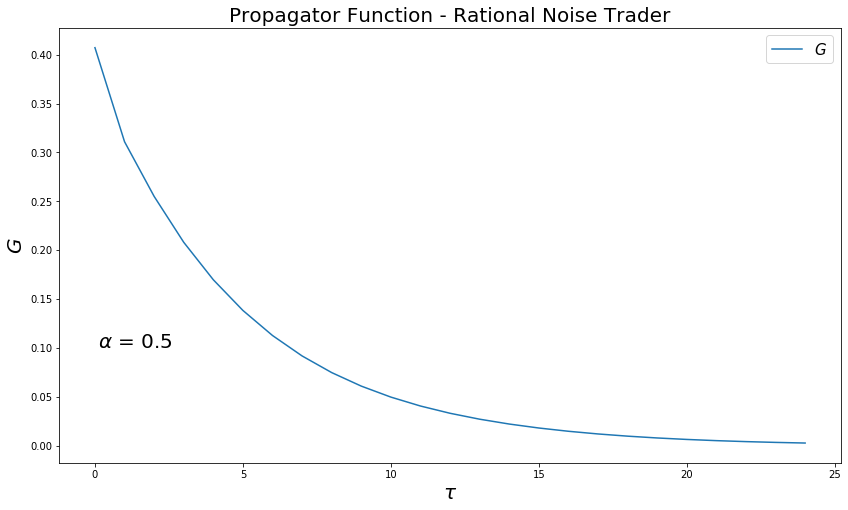

In [123]:
figure1 = plt.figure(figsize = (14,8))
plt.title("Propagator Function - Rational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)
plt.plot(np.arange(0,25), G_Rational[0,:25],label = r"$G$")
plt.text(0.1,0.1,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

**Plotting the Metrics For Convergence between sucessive propagators in G_s**

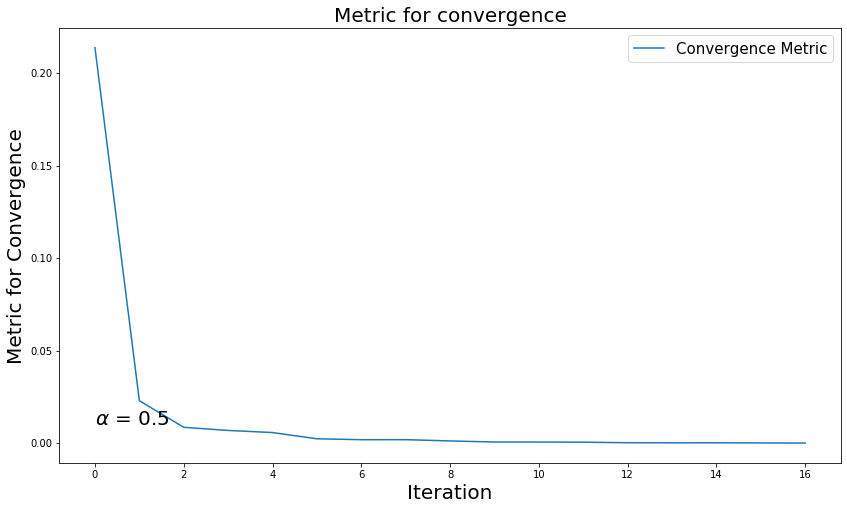

In [124]:
from scipy.spatial.distance import euclidean
figure2 = plt.figure(figsize = (14,8))
plt.title("Metric for convergence", fontsize = 20)
plt.xlabel(r"Iteration", fontsize = 20)
plt.ylabel(r"Metric for Convergence", fontsize = 20)
plt.plot(np.arange(0,len(Metrics_Convergence_Rational)), Metrics_Convergence_Rational, label = "Convergence Metric")
plt.text(0.01,0.01,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})

## Collapse between $G/G_{0}$ and $C_{\mu}/C_{\mu}^{0}$

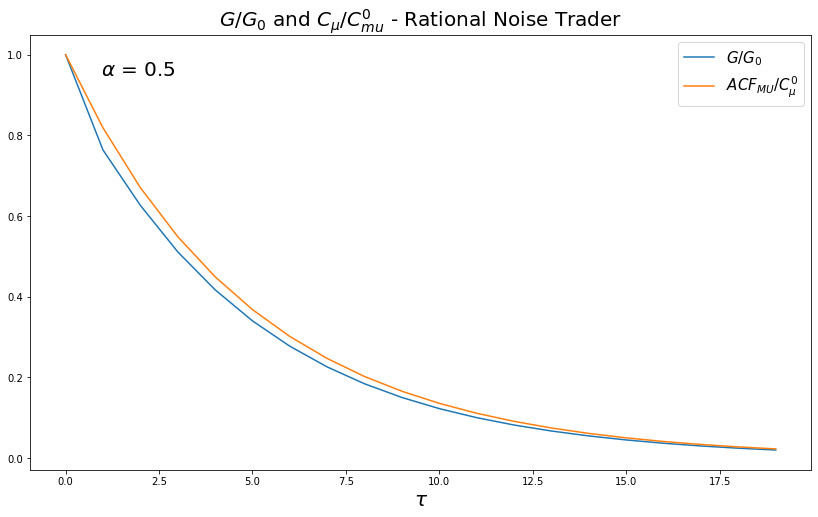

In [125]:
figure3 = plt.figure(figsize = (14,8))
plt.title(r"$G/G_{0}$ and $C_{\mu}/C_{mu}^{0}$ - Rational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.plot(np.arange(0,20), G_Rational[0,:20]/G_Rational[0,0], label = r"$G/G_{0}$")
plt.plot(np.arange(0,20), ACF_MU_Rational[0,:20]/C_MU_0, label = r"$ACF_{MU}/C_{\mu}^{0}$")
plt.text(0.95,0.95,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

## Collapse between $ACF_{Q}$ and $ACF_{NT}$ - Rational Noise Trader

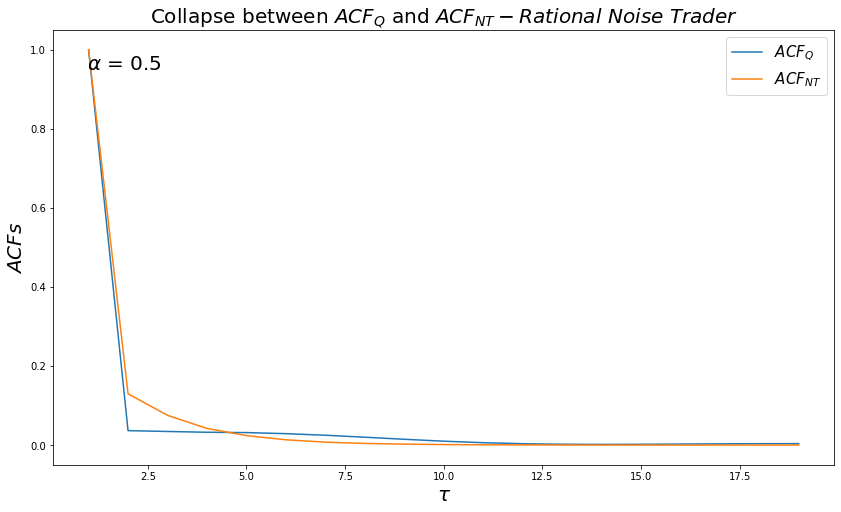

In [126]:
figure4 = plt.figure(figsize = (14,8))
plt.title(r"Collapse between $ACF_{Q}$ and $ACF_{NT} - Rational \ Noise \ Trader$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACFs$", fontsize = 20)
plt.plot(np.arange(1,20), ACFs_Q_Rational[len(G_s_Rational)-1][0,1:20]/ACFs_Q_Rational[len(G_s_Rational)-1][0,1], label = r"$ACF_{Q}$")
plt.plot(np.arange(1,20), ACFs_NT_Rational[len(G_s_Rational)-1][0,1:20]/ACFs_NT_Rational[len(G_s_Rational)-1][0,1] , label = r"$ACF_{NT}$")
plt.text(0.95,0.95,r"$\alpha$ = {}".format(alpha), fontsize = 20)
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Plotting ACF of the Informed Trader**

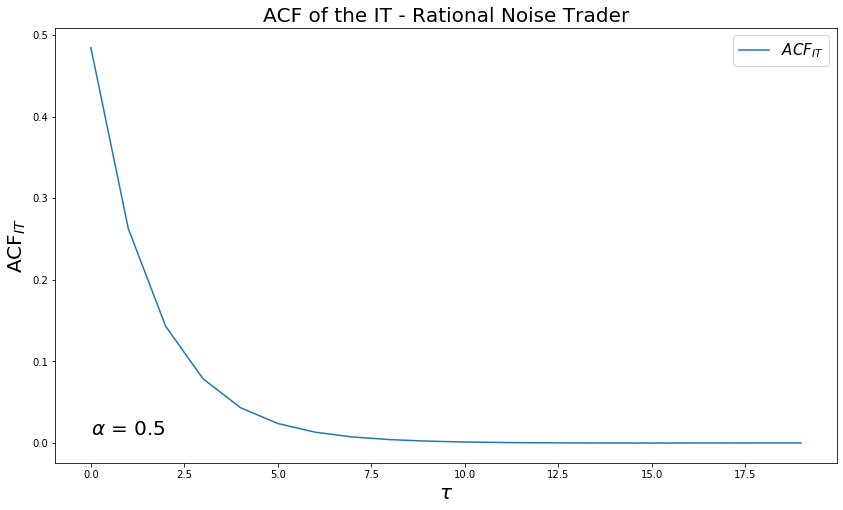

In [127]:
figure5 = plt.figure(figsize = (14,8))
plt.title("ACF of the IT - Rational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$\mathsf{ACF}_{IT}$", fontsize= 20)
plt.plot(np.arange(0,20), ACFs_IT[len(G_s_Rational)-1][0,:20], label = r"$ACF_{IT}$")
plt.text(0.01,0.01,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

## Transition Phase Analysis - Varying $\alpha$

**Propagator function for different values of $\alpha$**

In [128]:
T_phase_analysis = 100
T_it_phase_analysis = 100
G_0_seed = 1
alpha_G = 0.5
tau_MU = 5
tau_NT = 1
tau_IT = 1
alphas_vector = np.linspace(0.000001,1,20)
bound_for_convergence = 0.0001
cte = np.exp(-1/tau_MU)
C_MU_0 = ((1 - cte)/(cte))**2
C_NT_0 = 1
C_IT_0 = 1
tau = 2

# Target portfolio is a white noise
ACF_TGT = np.identity(T_phase_analysis)

seed_type_NT = "id"

results_for_different_alphas = []

for i in range (0,len(alphas_vector)):
    results_for_different_alphas.append(numerical_solver_rational_noise_trader(T_phase_analysis, T_it_phase_analysis, G_0_seed, alpha_G, alphas_vector[i], C_MU_0, tau_MU, ACF_TGT, seed_type_NT, C_NT_0, tau_NT, C_IT_0, tau_IT, tau, _, bound_for_convergence))

**Propagator functions for different values of $\alpha$**

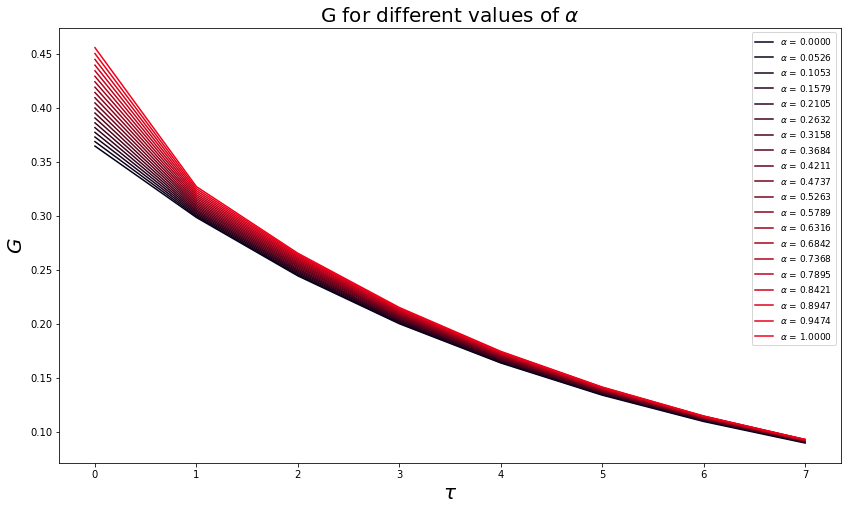

In [129]:
figure6 = plt.figure(figsize = (14,8))
plt.title(r"G for different values of $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,8), results_for_different_alphas[i][0][0,:8], color = color_conv((i)/20), label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
plt.legend(loc = 1, prop={'size': 9})
plt.show()

**Auto-covariance of the Noise Trader for different values of $\alpha$**

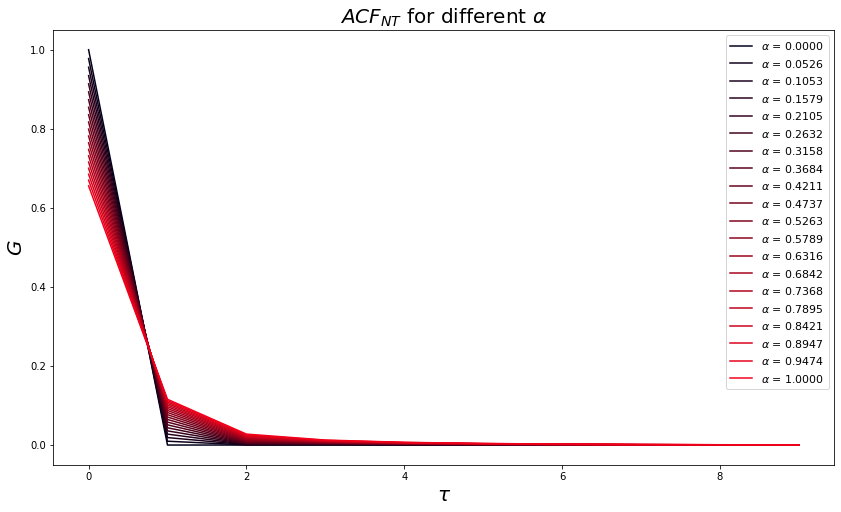

In [130]:
figure7 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{NT}$ for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,10), results_for_different_alphas[i][2][-1][0,:10], color = color_conv((i)/20), label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
#plt.yscale('log')
plt.legend(loc = 1, prop={'size': 11})
plt.show()

**Auto-covariance of the total excess demand for different values of $\alpha$**

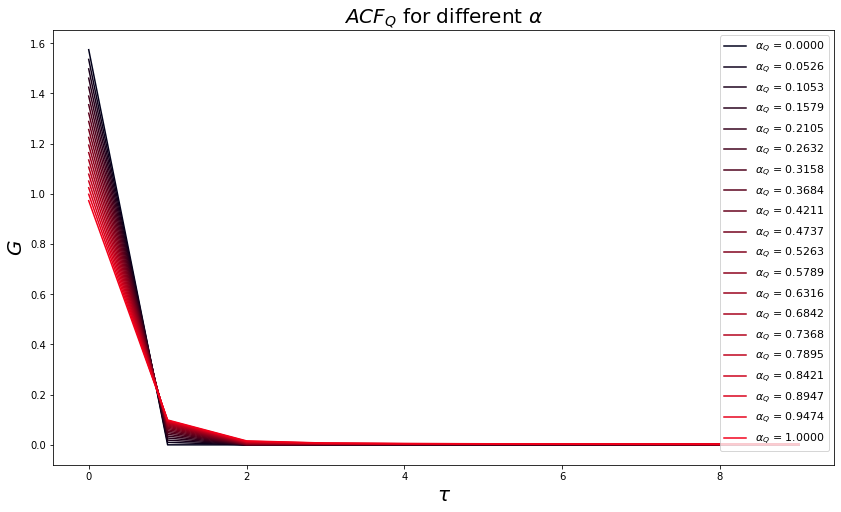

In [131]:
figure8 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{Q}$ for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,10),  results_for_different_alphas[i][4][-1][0,:10], color = color_conv((i)/20), label = r"$\alpha_{{Q}}$ = {:.4f}".format(alphas_vector[i]))

#plt.yscale('log')
plt.legend(loc = 1, prop={'size': 11})
plt.show()

**Superposition of the Auto-Covariance of the Noise Trader and the Total Excess Demand - Investigating the
Cammouflage of the IT**

**Biggest $\alpha$**

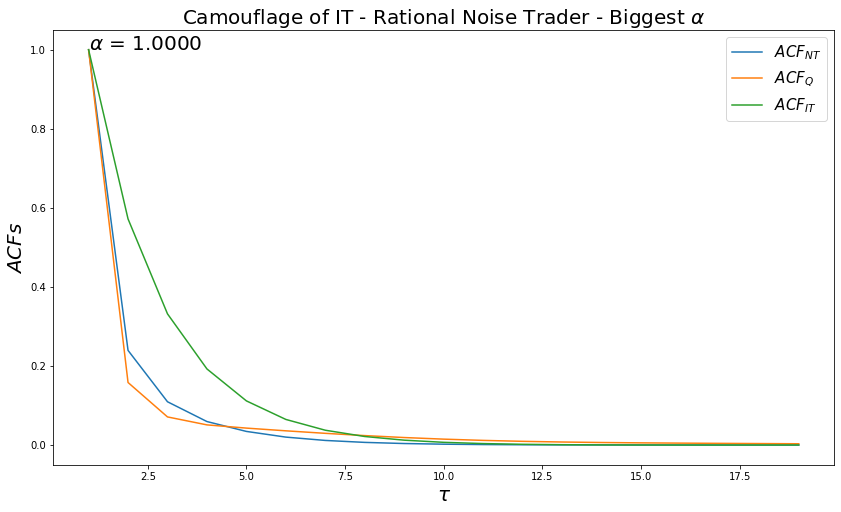

In [144]:
figure9 = plt.figure(figsize = (14,8))
plt.title(r"Camouflage of IT - Rational Noise Trader - Biggest $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACFs$", fontsize = 20)

for i in range(len(alphas_vector)-1,len(alphas_vector)):
    plt.plot(np.arange(1,20),  results_for_different_alphas[i][2][-1][0,1:20]/results_for_different_alphas[i][2][-1][0,1], label = r'$ACF_{NT}$')
    plt.plot(np.arange(1,20),  results_for_different_alphas[i][4][-1][0,1:20]/results_for_different_alphas[i][4][-1][0,1], label = r'$ACF_{Q}$')
    plt.plot(np.arange(1,20),  results_for_different_alphas[i][3][-1][0,1:20]/results_for_different_alphas[i][3][-1][0,1], label = r'$ACF_{IT}$')

    
plt.text(1,1,r"$\alpha$ = {:.4f}".format(alphas_vector[len(alphas_vector)-1]), fontsize = 20)
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Smallest $\alpha$**

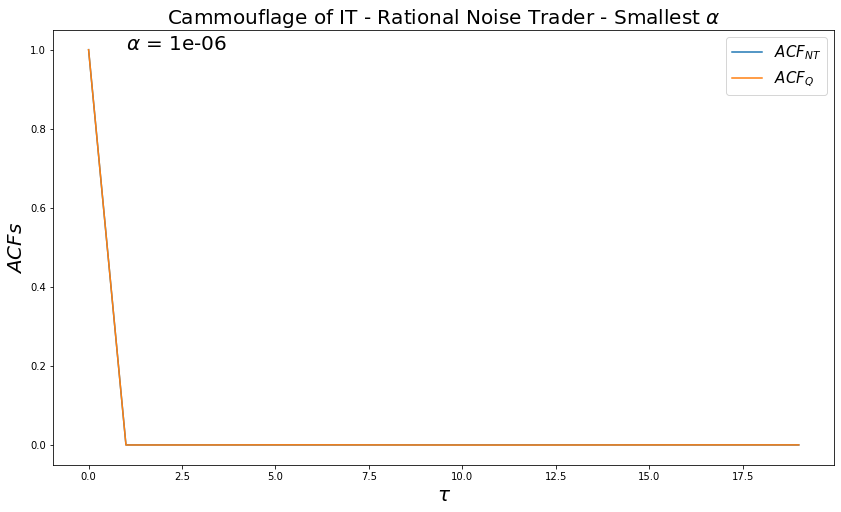

In [145]:
figure10 = plt.figure(figsize = (14,8))
plt.title(r"Cammouflage of IT - Rational Noise Trader - Smallest $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACFs$", fontsize = 20)

for i in range (0,1):
    plt.plot(np.arange(0,20),  results_for_different_alphas[i][2][-1][0,:20]/results_for_different_alphas[i][2][-1][0,0], label = r'$ACF_{NT}$')
    plt.plot(np.arange(0,20),  results_for_different_alphas[i][4][-1][0,:20]/results_for_different_alphas[i][4][-1][0,0], label = r'$ACF_{Q}$')
#plt.yscale('log')
plt.text(1,1,r"$\alpha$ = {}".format(alphas_vector[0]), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

## Variance Analysis

**Covariance of the Total Excess Demand for different values of $\alpha$**

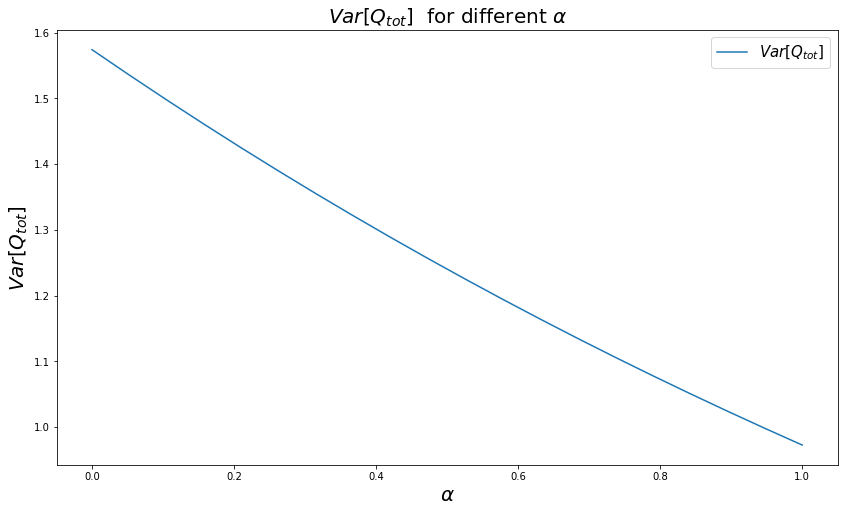

In [146]:
figure11 = plt.figure(figsize = (14,8))
plt.title(r"$Var[Q_{tot}]$  for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\alpha$", fontsize = 20)
plt.ylabel(r"$Var[Q_{tot}]$", fontsize = 20)


covariances_Q = []

for i in range(0, len(alphas_vector)):
    covariances_Q.append(results_for_different_alphas[i][4][-1][0,0])
    

plt.plot(alphas_vector, covariances_Q, label = r"$Var[Q_{tot}]$")
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Covariance of the Noise Trader's Demand for different values of $\alpha$**

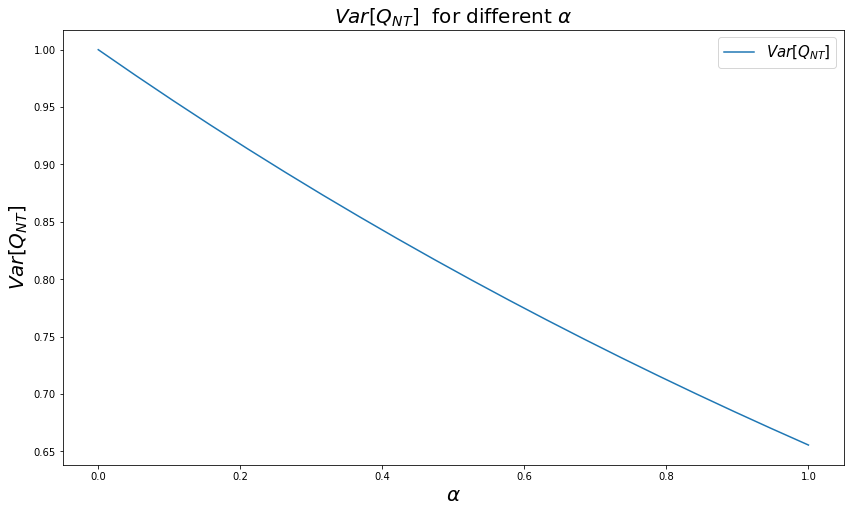

In [147]:
figure12 = plt.figure(figsize = (14,8))
plt.title(r"$Var[Q_{NT}]$  for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\alpha$", fontsize = 20)
plt.ylabel(r"$Var[Q_{NT}]$", fontsize = 20)


covariances_Q_NT = []

for i in range(0, len(alphas_vector)):
    covariances_Q_NT.append(results_for_different_alphas[i][2][-1][0,0])
    

plt.plot(alphas_vector, covariances_Q_NT, label = r"$Var[Q_{NT}]$")
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

## Studying Price Efficiency

**Price efficiency for the biggest $\alpha$**

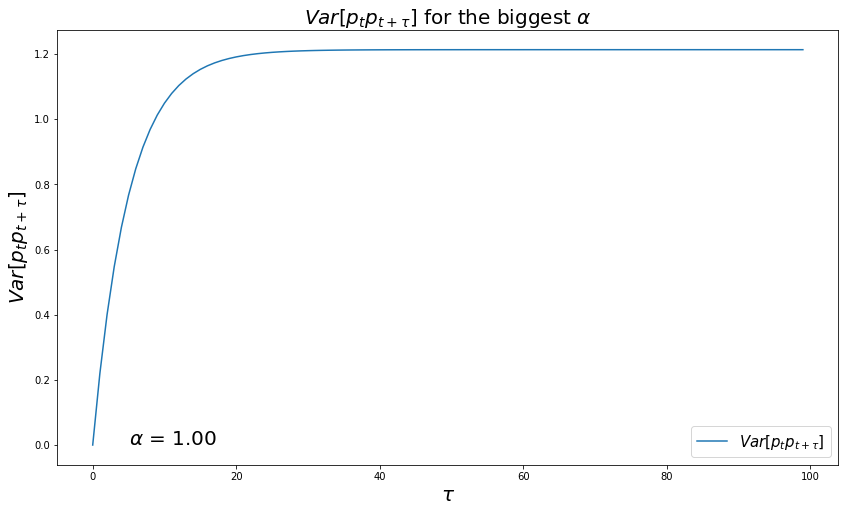

In [148]:
figure13 = plt.figure(figsize = (14,8))
plt.title(r"$Var[p_{t}p_{t + \tau}]$ for the biggest $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$Var[p_{t}p_{t + \tau}]$", fontsize = 20)

final_result = results_for_different_alphas[len(alphas_vector) - 1]

G_final = final_result[0]

ACF_Q_final = final_result[4][-1]

ACF_P_final = return_ACF_P(ACF_Q_final, G_final)


plt.plot(np.arange(0,T_phase_analysis), 2*ACF_P_final[0,0]*(1 - ACF_P_final[0,:]/ACF_P_final[0,0]), label = r"$Var[p_{t}p_{t + \tau}]$")
plt.text(5,0,r"$\alpha$ = {:.2f}".format(alphas_vector[len(alphas_vector)-1]), fontsize = 20)
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Price efficiency for different values of $\alpha$**

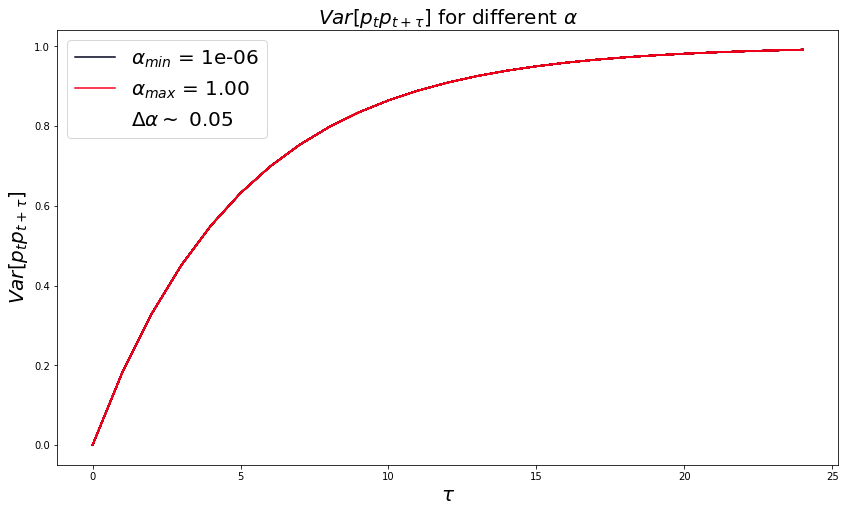

In [149]:
figure14 = plt.figure(figsize = (14,8))
plt.title(r"$Var[p_{t}p_{t + \tau}]$ for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$Var[p_{t}p_{t + \tau}]$", fontsize = 20)


final_results = []


for i in range(0,len(alphas_vector)):
    final_results.append(results_for_different_alphas[i])
 

ACFs_P = []

for i in range(0,len(alphas_vector)):
    G_final = final_results[i][0]
    ACF_Q_final = final_results[i][4][-1]
    ACFs_P.append(return_ACF_P(ACF_Q_final, G_final))
    
    

for i in range(0,len(alphas_vector)):
    #plt.plot(np.arange(0,25), (1 - ACFs_P[i][0,:25]/ACFs_P[i][0,0]), color = color_conv((i)/20), label = r"$\alpha$ = {:.6f}".format(alphas_vector[i]))
    if(i == 0):
        plt.plot(np.arange(0,25), (1 - ACFs_P[i][0,:25]/ACFs_P[i][0,0]), color = color_conv((i)/20), label = r"$\alpha_{{min}}$ = {:.0e}".format(alphas_vector[i]))
    if(i == 19):
        plt.plot(np.arange(0,25), (1 - ACFs_P[i][0,:25]/ACFs_P[i][0,0]), color = color_conv((i)/20), label = r"$\alpha_{{max}}$ = {:.2f}".format(alphas_vector[i]))
    if(i == 19):
        plt.plot([], [], ' ', label=r"$\Delta \alpha \sim $ {:.2f}".format(1/20))
    else:
        plt.plot(np.arange(0,25), (1 - ACFs_P[i][0,:25]/ACFs_P[i][0,0]), color = color_conv((i)/20))
        plt.plot(np.arange(0,25), (1 - ACFs_P[i][0,:25]/ACFs_P[i][0,0]), color = color_conv((i)/20))
#plt.plot(np.arange(0,25),2*(1 - ACF_MU_Rational[0,:25]/C_MU_0), label = r"$ACF_{MU}/C_{\mu}^{0}$")

#plt.yscale('log')
plt.legend(loc = 2 , prop={'size': 20})
plt.show()

## Analysis of Results - Irrational Noise Trader

In [143]:
T = 100
T_it = 100
G_0_seed = 1
alpha_G = 0.5 
tau_MU = 5
tau_NT = 1
cte = np.exp(-1/tau_MU)
C_MU_0 = ((1 - cte)/(cte))**2
C_NT_0 = 1

#numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, C_MU_0, C_NT_0, tau_MU, tau_NT)
G_Irrational, G_s_Irrational, ACF_Q_Irrational, ACF_NT_Irrational, ACF_MU_Irrational, ACF_P_Irrational, ACF_P_F_Irrational, ACF_IT_Irrational = numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, C_MU_0, C_NT_0, tau_MU, tau_NT)

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 21

This is iteration: 22

This is iteration: 23

This is iteration: 24

This is iteration: 25

This is iteration: 26

This is iteration: 27

This is iteration: 28

This is iteration: 29

This is iteration: 30

This is iteration: 31

This is iteration: 32

This is iteration: 33

This is iteration: 34

This is iteration: 35

This is iteration: 36

This is iteration: 37

This is iteration: 38

This is iteration: 39

This is iteration: 40

This is iteration: 41

This is iteration: 42

This is iteration: 43

This is iteration: 4

## Last propagator found - Irrational Noise Trader

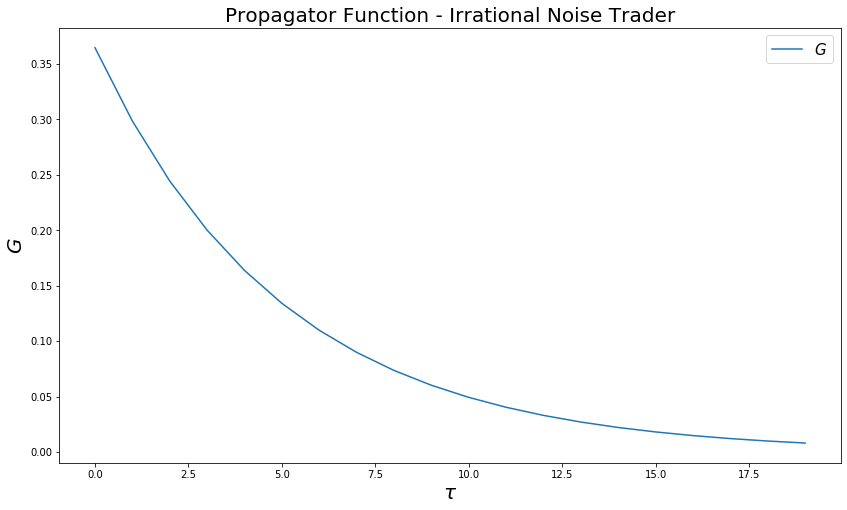

In [154]:
figure15 = plt.figure(figsize = (14,8))
plt.title("Propagator Function - Irrational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)
plt.plot(np.arange(0,20),G_Irrational[0,:20], label = r"$G$")
plt.legend(prop={'size': 15})
plt.show()

##  $G/G_{0}$ and $C_{\mu}/C_{\mu}^{0}$

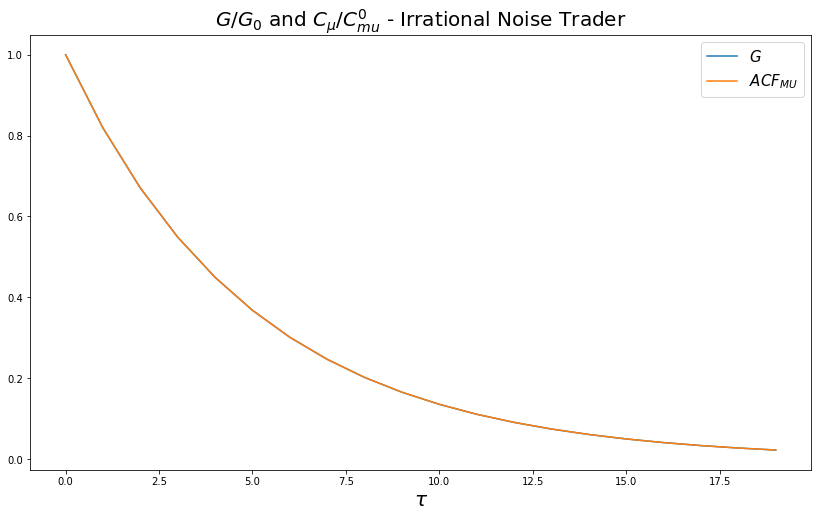

In [155]:
figure16 = plt.figure(figsize = (14,8))
plt.title(r"$G/G_{0}$ and $C_{\mu}/C_{mu}^{0}$ - Irrational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.plot(np.arange(0,20), G_Irrational[0,:20]/G_Irrational[0,0], label = r"$G$")
plt.plot(np.arange(0,20), ACF_MU_Irrational[0,:20]/C_MU_0, label = r"$ACF_{MU}$")
plt.legend(prop={'size': 15})
plt.show()

## Collapse between $ACF_{Q}$ and $ACF_{NT}$ - Irrational Noise Trader

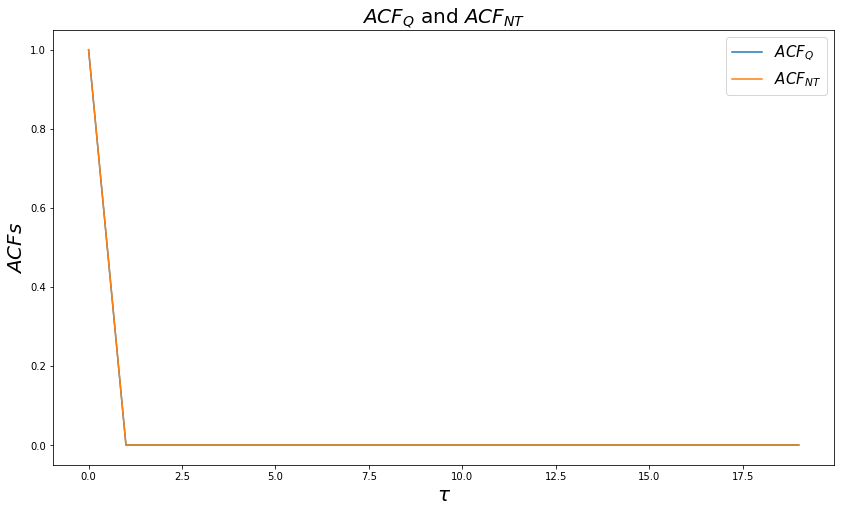

In [156]:
figure17 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{Q}$ and $ACF_{NT}$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACFs$", fontsize = 20)
plt.plot(np.arange(0,20),ACF_Q_Irrational[0,:20]/ACF_Q_Irrational[0,0], label = r"$ACF_{Q}$")
plt.plot(np.arange(0,20), ACF_NT_Irrational[0,:20]/ACF_NT_Irrational[0,0], label = r"$ACF_{NT}$")
plt.legend(prop={'size': 15})
plt.show()

## $ACF_{IT}$

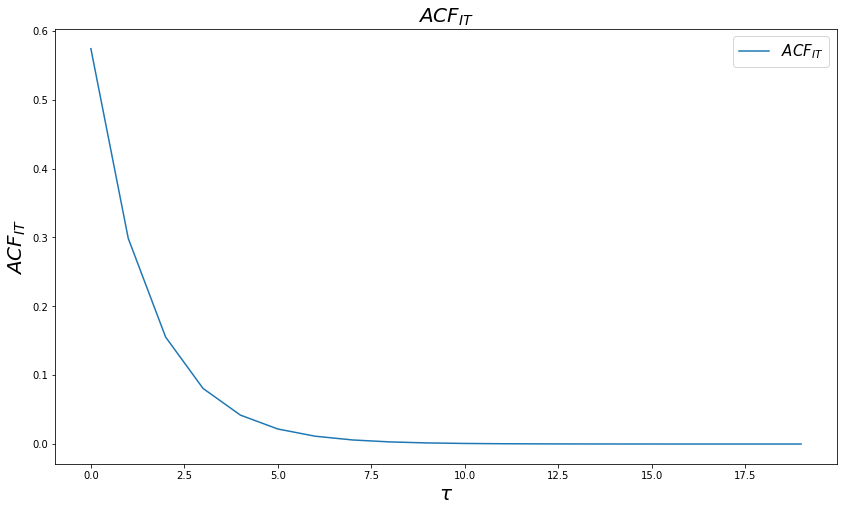

In [157]:
figure18 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{IT}$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{IT}$", fontsize = 20)
plt.plot(np.arange(0,20), ACF_IT_Irrational[0,:20], label = r"$ACF_{IT}$")
plt.legend(prop={'size': 15})
plt.show()

## $ACF_{P}$

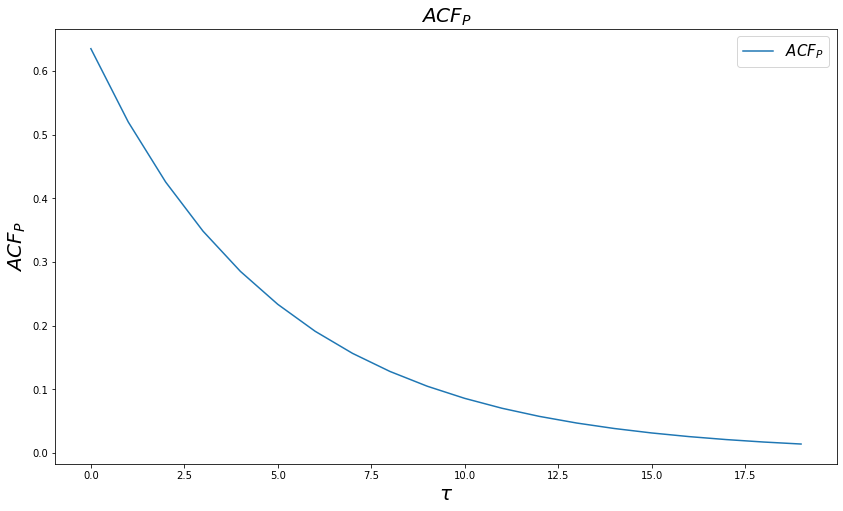

In [158]:
figure19 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{P}$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{P}$", fontsize = 20)
plt.plot(np.arange(0,20), ACF_P_Irrational[0,:20], label = r"$ACF_{P}$")
plt.legend(prop={'size': 15})
plt.show()

## Comparison between Irrational and Rational Noise Trader Cases

**Propagator Comparison**

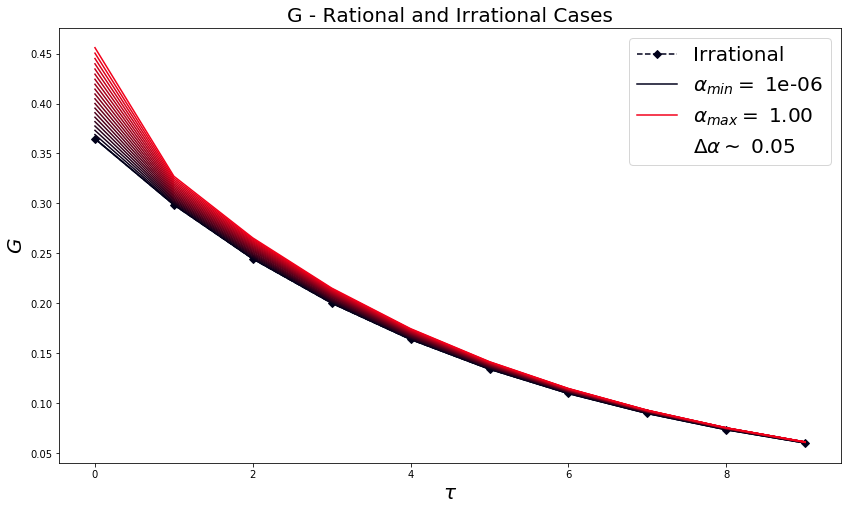

In [159]:
figure20 = plt.figure(figsize = (14,8))
plt.title(r"G - Rational and Irrational Cases", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)


plt.plot(np.arange(10), G_Irrational[0,:10],linestyle='dashed',  label = "Irrational", marker = 'D', color = color_conv(0))    
plt.legend(loc = 1, prop={'size': 8})
for i in range (0,20):
    if(i == 0):
        plt.plot(np.arange(0,10), results_for_different_alphas[i][0][0,:10], color = color_conv((i)/20), label=r"$\alpha_{{min}} = $ {:.0e}".format(alphas_vector[0]))
    if(i == 19):
         plt.plot(np.arange(0,10), results_for_different_alphas[i][0][0,:10], color = color_conv((i)/20), label=r"$\alpha_{{max}} = $ {:.2f}".format(alphas_vector[-1]))
    if(i == 19):
        plt.plot([], [], ' ', label=r"$\Delta \alpha \sim $ {:.2f}".format(1/20))
    else:
        plt.plot(np.arange(0,10),  results_for_different_alphas[i][0][0,:10], color = color_conv((i)/20))
        



plt.legend(loc = 1, prop={'size': 20})
plt.show()


#label = r"$\alpha$ = {:.5f}".format(alphas_vector[i])

**$ACF_{Q}$**

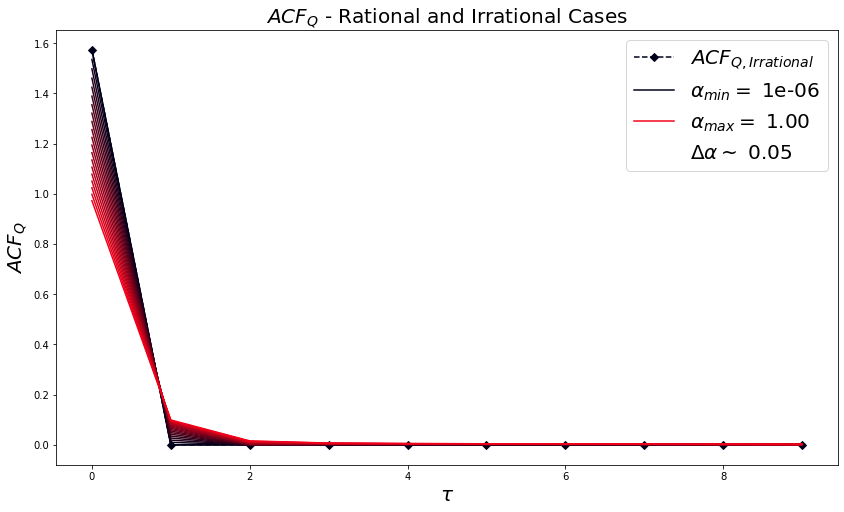

In [160]:
figure21 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{Q}$ - Rational and Irrational Cases" , fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{Q}$", fontsize = 20)


plt.plot(np.arange(0,10), ACF_Q_Irrational[0,:10], label = r"$ACF_{Q,Irrational}$", linestyle = 'dashed', marker = 'D', color = color_conv(0))

for i in range (0,20):
    if(i == 0):
        plt.plot(np.arange(0,10), results_for_different_alphas[i][4][-1][0,:10], color = color_conv((i)/20), label=r"$\alpha_{{min}} = $ {:.0e}".format(alphas_vector[0]))
    if(i == 19):
        plt.plot(np.arange(0,10), results_for_different_alphas[i][4][-1][0,:10], color = color_conv((i)/20), label=r"$\alpha_{{max}} = $ {:.2f}".format(alphas_vector[-1]))
    if(i == 19):
        plt.plot([], [], ' ', label=r"$\Delta \alpha \sim $ {:.2f}".format(1/20))
    else:
        plt.plot(np.arange(0,10),  results_for_different_alphas[i][4][-1][0,:10], color = color_conv(i/20))
#plt.yscale('log')
plt.legend(loc = 1, prop={'size': 20})
plt.show()

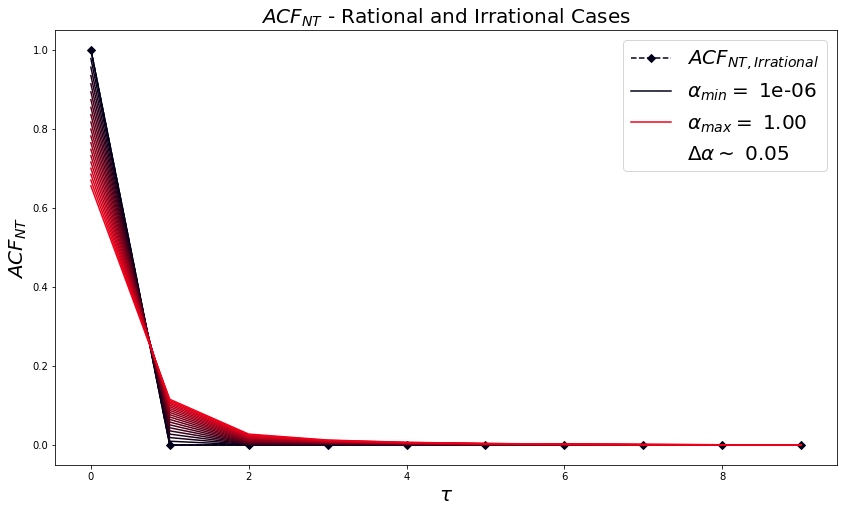

In [161]:
figure22 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{NT}$ - Rational and Irrational Cases" , fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{NT}$", fontsize = 20)

plt.plot(np.arange(0,10), ACF_NT_Irrational[0,:10], label = r"$ACF_{NT,Irrational}$", linestyle = 'dashed', marker = 'D', color = color_conv(0))

for i in range (0,20):
    if(i == 0):
        plt.plot(np.arange(0,10), results_for_different_alphas[i][2][-1][0,:10], color = color_conv((i)/20), label=r"$\alpha_{{min}} = $ {:.0e}".format(alphas_vector[0]))
    if(i == 19):
        plt.plot(np.arange(0,10), results_for_different_alphas[i][2][-1][0,:10], color = color_conv((i)/20), label=r"$\alpha_{{max}} = $ {:.2f}".format(alphas_vector[-1]))
    if(i == 19):
        plt.plot([], [], ' ', label=r"$\Delta \alpha \sim $ {:.2f}".format(1/20))
    else:
        plt.plot(np.arange(0,10),  results_for_different_alphas[i][2][-1][0,:10], color = color_conv(i/20))
#plt.yscale('log')
plt.legend(loc = 1, prop={'size': 20})
plt.show()


## Coding the tester for convergence - Two degrees of freedom: $Var(q^{tgt})$ and $\tau_{\mu}$

**Tester function**

In [164]:
def convergence_tester(T_analysis, T_it_max, number_of_tests, bound_for_convergence, alpha_min, alpha_max, var_tgt_min,
                       var_tgt_max, tau_mu_min, tau_mu_max, initial_seed_type, G_0_seed, alpha_G, C_NT_0, tau_NT, C_IT_0, tau_IT, tau):
    
    #C_NT_0, tau_NT, C_IT_0, tau_IT are only used in the case of initial_seed_type = "mark"
    
    counter = 1
    
    ACF_1_NT = np.zeros((1,T_analysis))
    ACF_1_Q = np.zeros((1,T_analysis))
    
    alpha_vector = np.linspace(alpha_min, alpha_max, number_of_tests)
    tau_mu_vector = np.linspace(tau_mu_min, tau_mu_max, number_of_tests)
    #var_tgt_vector = np.linspace(var_tgt_min, var_tgt_max, number_of_tests)
    
    var_tgt_vector = np.array([1])
    
    results = np.zeros((number_of_tests, number_of_tests, number_of_tests), dtype = object)
    convergence = np.zeros((number_of_tests, number_of_tests, number_of_tests))
    C_p = np.zeros((number_of_tests, number_of_tests, number_of_tests))
    collapse_measure = np.zeros((number_of_tests, number_of_tests, number_of_tests))
    
    last_result = np.zeros(1, dtype = object)
    
    I = np.identity(T_analysis)
    
    given_seeds = np.zeros(3, dtype = object) #Tuple -> List where first item is G_seed, second item is ACF_NT_seed and final item 
                     #is ACF_IT_seed
    
    seed_type = initial_seed_type
    
    for a in range(0, number_of_tests):
        for t in range(0, number_of_tests):
            for v in range(0, 1):
                
                ACF_TGT = var_tgt_vector[v]*I
                                
                if seed_type == "given":
                    given_seeds[0] = last_result[0][0]
                    given_seeds[1] = last_result[0][2][-1]
                    given_seeds[2] = last_result[0][3][-1]
                
                
                cte = np.exp(-1/tau_mu_vector[t])
                C_MU_0 = ((1 - cte)/(cte))**2
                
                results[a,t,v] = list(numerical_solver_rational_noise_trader(T_analysis, T_it_max, G_0_seed, alpha_G,
                                                                      alpha_vector[a], C_MU_0, tau_mu_vector[t],
                                                                      ACF_TGT, seed_type, C_NT_0, tau_NT, C_IT_0,
                                                                      tau_IT, tau, given_seeds, bound_for_convergence))
                
                last_result[0] = results[a,t,v]
                
                convergence[a,t,v] = results[a,t,v][-2]
                
                C_p[a,t,v]  = results[a,t,v][-3][0,0]
                
                collapse_measure[a,t,v] = err_ACF(results[a,t,v][4][-1][0,:], results[a,t,v][2][-1][0,:])
                #print(f"The error is {collapse_measure[a,t,v]} \n")
                
                if(convergence[a,t,v]):
                    seed_type = "given"
                else:
                    seed_type = "mark"
                    
                if(counter == 1):
                    ACF_1_NT = results[a,t,v][2][-1][0,:]
                    ACF_1_Q = results[a,t,v][4][-1][0,:]
                    
                
                print(f"Test {counter} is completed\n")
                counter += 1

    
    return results, convergence, C_p, collapse_measure, alpha_vector, tau_mu_vector, var_tgt_vector, ACF_1_NT, ACF_1_Q


## Runnig the Convergence Tester

In [167]:
T_analysis = 100
T_it_max = 500
number_of_tests = 3
bound_for_convergence = 0.0001
alpha_min = 0.000001
alpha_max = 1
var_tgt_min = 1
var_tgt_max = 1
tau_mu_min = 1
tau_mu_max = 10 # maximum for obtaining convergence with this max alpha
initial_seed_type = "mark"
G_0_seed = 1
alpha_G = 0.5
C_NT_0 = 1
tau_NT = 1
C_IT_0 = 1
tau_IT = 1
tau = 2

results, convergence, C_p, collapse_measure, alpha_vector, tau_mu_vector, var_tgt_vector, ACF_1_NT, ACF_1_Q = convergence_tester(T_analysis, T_it_max, number_of_tests, bound_for_convergence, alpha_min, alpha_max, var_tgt_min,
                       var_tgt_max, tau_mu_min, tau_mu_max, initial_seed_type, G_0_seed, alpha_G, C_NT_0, tau_NT, C_IT_0, tau_IT, tau)

Test 1 is completed

Test 2 is completed



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in matmul
  
/opt/anaconda3/lib/python3.7/site-packages/ipykern

Test 3 is completed

Test 4 is completed

Test 5 is completed



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in add
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Test 6 is completed

Test 7 is completed

Test 8 is completed

Test 9 is completed



## Studying the Convergence Region for Different $\alpha$ values

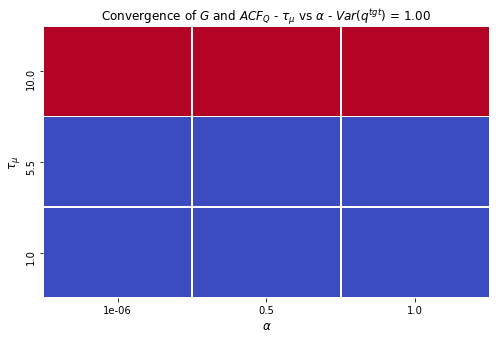

In [171]:
alpha_unicode = "\u03B1"

transformed_alpha_vector = np.zeros(number_of_tests)
transformed_alpha_vector[0] = alpha_vector[0].round(6)
transformed_alpha_vector[1:] = alpha_vector[1:].round(2)

for i in range(0, 1):
    plt.subplots(figsize=(8,5))
    sns.heatmap(np.flip(convergence[:,:,i].T,0), linewidths=.5, cmap = 'coolwarm_r', vmin = 0, vmax = 1, xticklabels = transformed_alpha_vector, yticklabels = tau_mu_vector[::-1], cbar = False, fmt = '')
    plt.ylabel(r"$\tau_{\mu}$", size = 12)
    plt.xlabel(r"$\alpha$", size = 12)
    plt.title(r"Convergence of $G$ and $ACF_{{Q}}$ - $\tau_{{\mu}}$ vs $\alpha$ - $Var(q^{{tgt}})$ = {:.2f}".format(var_tgt_vector[i]))
    plt.show()

## Last Propagator Found for each set of parameters

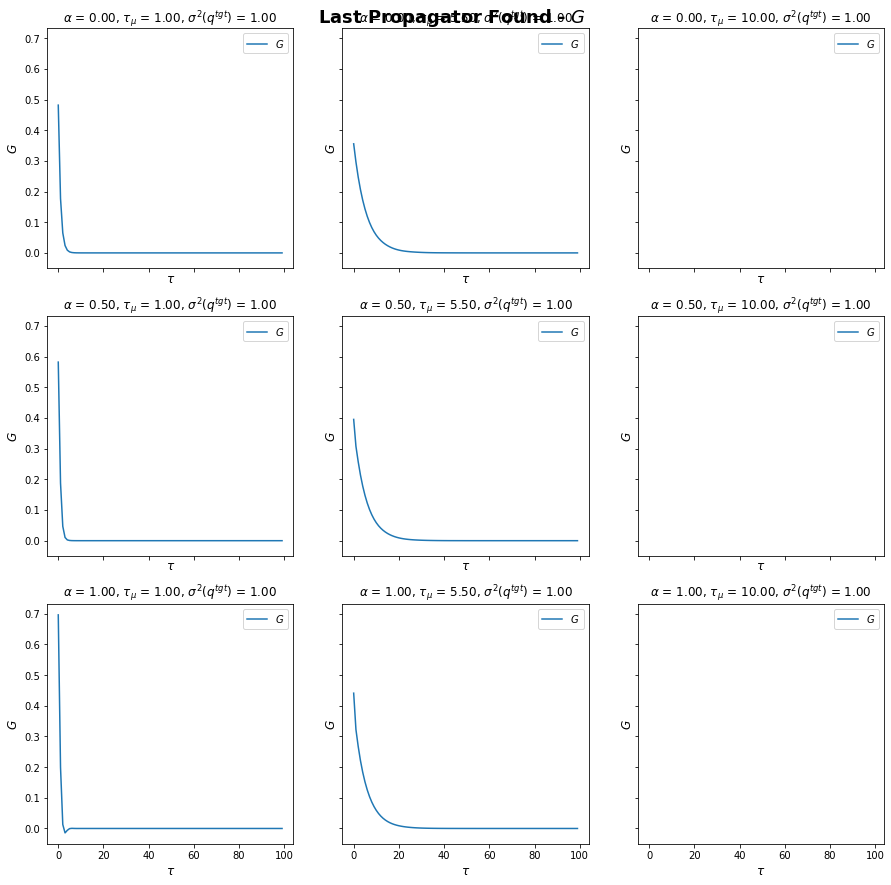

In [172]:
figure23, axs23 = plt.subplots(number_of_tests, number_of_tests, sharex = True , sharey = True , figsize = (5*number_of_tests,5*number_of_tests))

figure23.suptitle(r"Last Propagator Found - $G$", fontsize = 18, y = 0.9, weight="bold")


for k in range(0, number_of_tests):
    for i in range(0, number_of_tests):
            axs23[k,i].plot(np.arange(0, T_analysis), results[k,i,0][0][0,:], label = "$G$")
            axs23[k,i].legend()
            axs23[k,i].set_ylabel(r"$G$", size = 12)
            axs23[k,i].set_xlabel(r"$\tau$", size = 12)
            axs23[k,i].title.set_text( r"$\alpha$ = {:.2f}, $\tau_{{\mu}}$ = {:.2f}, $\sigma^{{2}}(q^{{tgt}})$ = {:.2f}".format(alpha_vector[k], tau_mu_vector[i], var_tgt_vector[0]))

## Investigating the Camouflage Property for each set of parameters

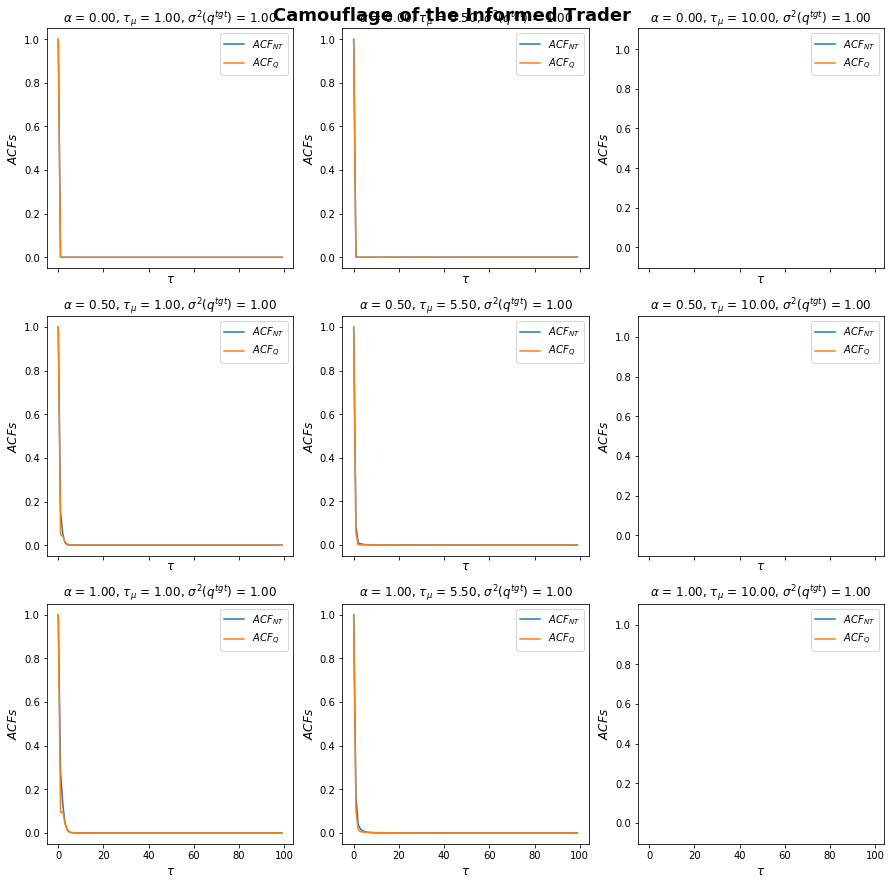

In [173]:
figure24, axs24 = plt.subplots(number_of_tests, number_of_tests, sharex = True , sharey = False , figsize = (5*number_of_tests,5*number_of_tests))

figure24.suptitle("Camouflage of the Informed Trader", fontsize = 18, y = 0.9, weight="bold")


for k in range(0, number_of_tests):
    for i in range(0, number_of_tests):
            axs24[k,i].plot(np.arange(0, T_analysis), results[k,i,0][2][-1][0,:]/results[k,i,0][2][-1][0,0], label = r"$ACF_{NT}$")
            axs24[k,i].legend()
            axs24[k,i].plot(np.arange(0, T_analysis), results[k,i,0][4][-1][0,:]/results[k,i,0][4][-1][0,0], label = r"$ACF_{Q}$")
            axs24[k,i].legend()
            axs24[k,i].set_ylabel(r"$ACFs$", size = 12)
            axs24[k,i].set_xlabel(r"$\tau$", size = 12)
            axs24[k,i].title.set_text( r"$\alpha$ = {:.2f}, $\tau_{{\mu}}$ = {:.2f}, $\sigma^{{2}}(q^{{tgt}})$ = {:.2f}".format(alpha_vector[k], tau_mu_vector[i], var_tgt_vector[0]))

## Investigating the variance of the price $Var(p)$ as function of $\tau_{\mu}$ and $\alpha$, when $Var(p^{IT}) = 1$

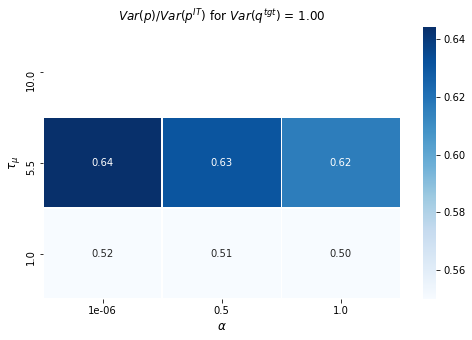

<Figure size 432x288 with 0 Axes>

In [175]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

transformed_alpha_vector = np.zeros(number_of_tests)
transformed_alpha_vector[0] = alpha_vector[0].round(6)
transformed_alpha_vector[1:] = alpha_vector[1:].round(2)

for i in range(0, 1):
    plt.subplots(figsize=(8,5))
    sns.heatmap(np.flip((C_p[:,:,i].T),0),linewidths=.5, cmap = 'Blues', xticklabels = transformed_alpha_vector, yticklabels = tau_mu_vector.round(2)[::-1], cbar = True, fmt = '.2f', annot = True, vmin = 0.55)
    plt.ylabel(r"$\tau_{\mu}$", size = 12)
    plt.xlabel(r"$\alpha$", size = 12)
    plt.title(r"$Var(p)/Var(p^{{IT}})$ for $Var(q^{{tgt}})$ = {:.2f}".format(var_tgt_vector[i]))
    plt.show()
    plt.tight_layout()

## Measuring the Camouflage of the IT - How much collapse do we have between $ACF_{Q}$ and $ACF_{NT}$ ?

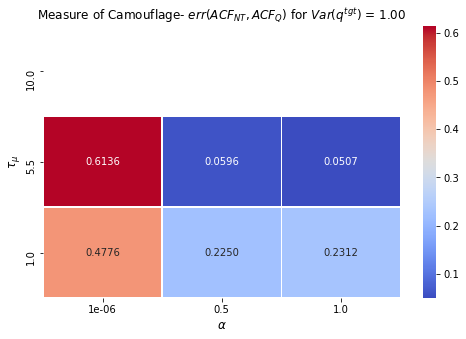

<Figure size 432x288 with 0 Axes>

In [177]:
transformed_alpha_vector = np.zeros(number_of_tests)
transformed_alpha_vector[0] = alpha_vector[0].round(6)
transformed_alpha_vector[1:] = alpha_vector[1:].round(2)

for i in range(0, 1):
    plt.subplots(figsize=(8,5))
    sns.heatmap(np.flip(collapse_measure[:,:,i].T,0),linewidths=.5, cmap = 'coolwarm', xticklabels = transformed_alpha_vector, yticklabels = tau_mu_vector.round(2)[::-1], cbar = True, fmt = '.4f', annot = True)
    plt.ylabel(r"$\tau_{\mu}$", size = 12)
    plt.xlabel(r"$\alpha$", size = 12)
    plt.title(r"Measure of Camouflage- $err(ACF_{{NT}}, ACF_{{Q}})$ for $Var(q^{{tgt}})$ = {:.2f}".format(var_tgt_vector[i]))
    plt.show()
    plt.tight_layout()

## Simulating the Market!

**Simulating a stochastic process given its ACF from a white noise**

In [25]:
from scipy.linalg import cholesky

def generate_order_flow(ACF, number_of_simulations):
    T = ACF.shape[0]
    white_noise = np.random.normal(0,1,(number_of_simulations,T))
    ACF_cholesky = cholesky(ACF)
    order_flow = np.matmul(ACF_cholesky, white_noise.transpose())
    return order_flow

**Functions for constructing the mean ACF of a series of realizations for a stochastic process**

In [26]:
def return_mean_ACF(order_flow, T, number_of_simulations):
    ACF = np.zeros(T)
    for i in range(0,number_of_simulations):
        ACF += return_series_autocovariance_for_lag(order_flow[i],order_flow[i],np.arange(0,T))/number_of_simulations
    return ACF

In [27]:
def return_series_autocovariance_for_lag(x, y, taus):
    """Inputs :
    x: pd.Series
    y: pd.Series
    taus: array of integers, representinthe lags
    Returns:
    A numpy array containing the correlation function as the average x(t)*y(t+tau)
    for each value of tau in taus"""
    def c_group(T):
        return (x*y.shift(-T)).mean()
    c_g = np.vectorize(c_group)
    return c_g(taus)

**Numerical Solver for Simulation**

In [28]:
def numerical_solver_simulation(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type, C_NT_0, tau_NT, C_IT_0, tau_IT, tau, given_seeds, bound_for_convergence):
        
    if seed_type != "given": 
        G = return_G(G_0_seed, alpha_G, T)
    else:
        G = given_seeds[0]
    
    ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)
    F_MU = -np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1)

    G_s = []
    Ds_list = []
    ACFs_NT = []
    ACFs_Q = []
    ACFs_IT = []
    metrics_convergence = []
    
    for iteration in range(0,T_it):
        
        G_s.append(G)
        
        if(iteration == 0):
            if seed_type == "mark":
                ACF_NT = return_Markovian_ACF(C_NT_0, tau_NT, T)
                ACF_IT = return_Markovian_ACF(C_IT_0, tau_IT, T)
            if seed_type == "id":
                ACF_NT = np.identity(T)
                ACF_IT = np.identity(T)
            if seed_type == "given":
                ACF_NT = given_seeds[1]
                ACF_IT = given_seeds[2]
   
        Ds = return_Ds(G, alpha, ACF_NT, ACF_IT, F_MU, tau)
    
        Ds_list.append(Ds)
        
        ACF_Q = return_ACF_Q(ACF_MU, ACF_TGT, Ds)
        
        K = kalman_filter(G, ACF_MU, ACF_Q, Ds[0])

        G = new_G_from_equilibrium(G,K,F_MU) 

        ACF_NT = return_ACF_NT(ACF_MU, ACF_TGT, Ds)
        
        ACF_IT = return_ACF_IT(ACF_MU, ACF_TGT, Ds)
        ACF_IT = make_ACF_IT_invertible(ACF_IT)
        
        #plt.plot(np.arange(0,T), G[0,:T], label = r"$G$")
        #plt.legend()
        #plt.show()
        
        ACFs_IT.append(ACF_IT)
        ACFs_NT.append(ACF_NT)
        ACFs_Q.append(ACF_Q)
        
        #plt.plot(np.arange(0,T), ACF_NT[0,:T]/ACF_NT[0,0], label = r"$ACF_{NT}$")
        #plt.plot(np.arange(0,T), ACF_Q[0,:T]/ACF_Q[0,0],  label = r"$ACF_{Q}$")
        #plt.legend()
        #plt.show()
        
        #metric_for_convergence = err_G(G_s[-1], G[0,:])
        #metrics_convergence.append(metric_for_convergence)
            
        #print(f"This is iteration: {iteration + 1}\n")
        #print(f"The metric for convergence is {metric_for_convergence}\n")
        #print(f"Alpha is: {alpha}\n")
        #print(f"Tau mu is : {tau_MU}\n")
        #print(f"Var(TGT) is: {ACF_TGT[0][0]}\n")
        
        #if(math.isnan(metric_for_convergence)):
        #    convergence = 0
        #    break
        
        #if(iteration <= T_it - 1 and metric_for_convergence < bound_for_convergence):
        #    convergence = 1
        #    break
            
        #if(iteration == T_it - 1 and metric_for_convergence > bound_for_convergence):
        #    convergence = 0
        #    break
        
        #print(f"Iteration {iteration + 1} is finished\n")
        
    
    ACF_P = return_ACF_P(ACF_Q, G) 
    
    return G, Ds, G_s, Ds_list, ACFs_NT, ACFs_IT, ACFs_Q, ACF_MU, ACF_P #, convergence, metrics_convergence

**Function to return the total excess order flow**

In [29]:
def return_total_order_flow(D_MU, D_TGT, dividends_flow, target_portfolio_order_flow):
    return np.matmul(D_MU, dividends_flow) + np.matmul(D_TGT, target_portfolio_order_flow)

**Function to return the NT's order flow**

In [30]:
def return_NT_order_flow(D_MU_NT, D_TGT_NT, dividends_flow, target_portfolio_order_flow):
    return np.matmul(D_MU_NT, dividends_flow) + np.matmul(D_TGT_NT, target_portfolio_order_flow)

**Function to return the IT's order flow**

In [31]:
def return_IT_order_flow(D_MU_IT, D_TGT_IT, dividends_flow, target_portfolio_order_flow):
    return np.matmul(D_MU_IT, dividends_flow) + np.matmul(D_TGT_IT, target_portfolio_order_flow)

**Function to construct the price process given total order flow and G**

In [32]:
def return_price_series(total_order_flow, G):
    
    price_series = np.matmul(G, total_order_flow)

    return price_series

**Function to construct the fundamental price process given dividends flow and $\tau_{\mu}$**

In [33]:
def return_fundamental_price_series(dividends_flow, tau_MU):
    
    q = 1- np.exp(-1/tau_MU)
    p_F = dividends_flow/q

    return p_F

**Function to construct the IT's estimated price series given dividends flow and $\tau_{\mu}$**

In [34]:
def return_IT_estimated_price_series(dividends_flow, tau_MU):
    dividends_flow = dividends_flow[1:, :]
    cte = np.exp(-1/tau_MU)
    q = 1- cte
    p_IT = (cte*dividends_flow)/q
    
    return p_IT

**Simulating the dividends order flow**

In [35]:
T = 100

In [36]:
tau_MU = 5
cte = np.exp(-1/tau_MU)
C_MU_0 = ((1 - cte)/(cte))**2

ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)

In [37]:
number_of_simulations = 10000
dividends_flow = generate_order_flow(ACF_MU, number_of_simulations)

**Simulating the target portfolio process**

In [38]:
Var_TGT = 1
ACF_TGT = Var_TGT*np.identity(T) ## Var_tgt is a white noise process

In [39]:
target_portfolio_order_flow = generate_order_flow(ACF_TGT, number_of_simulations)

**Running the solver for getting the stationary G and Ds**

In [40]:
T_it = 100
G_0_seed = 1
alpha_G = 0.5
alpha = 1.5
seed_type = "mark"
C_NT_0 = 1
tau_NT = 1
C_IT_0 = 1
tau_IT = 1
tau = 6
#bound_for_convergence = 0.00001


numerical_solution = numerical_solver_simulation(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type, C_NT_0, 
                            tau_NT, C_IT_0, tau_IT, tau, _ , _)


**Retrieving the G array**

In [41]:
G = numerical_solution[0]

**G**

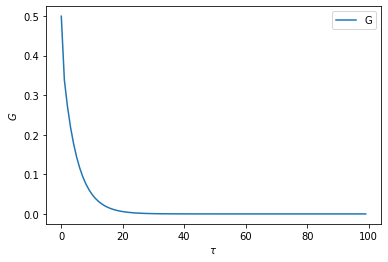

In [42]:
plt.plot(np.arange(0,T), G[0, :], label = "G")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G$")
plt.legend()

**Retrieving the Ds matrices**

In [43]:
D_MU = numerical_solution[3][-1][0]
D_TGT =  numerical_solution[3][-1][1]
D_MU_NT =  numerical_solution[3][-1][2]
D_TGT_NT =  numerical_solution[3][-1][3] 
D_MU_IT =  numerical_solution[3][-1][4]
D_TGT_IT =  numerical_solution[3][-1][5]

**Retrieving ACFs**

In [44]:
ACF_NT = numerical_solution[4][-1][0,:]
ACF_Q = numerical_solution[6][-1][0,:]

**Simulating the NT's order flow**

In [45]:
NT_order_flow = return_NT_order_flow(D_MU_NT, D_TGT_NT, dividends_flow, target_portfolio_order_flow)

**Simulating the IT's order flow**

In [46]:
IT_order_flow = return_IT_order_flow(D_MU_IT, D_TGT_IT, dividends_flow, target_portfolio_order_flow)

**Simulating the total excess order flow**

In [47]:
total_order_flow = return_total_order_flow(D_MU, D_TGT, dividends_flow, target_portfolio_order_flow)

**Generating the price series**

In [48]:
price_simulations = return_price_series(total_order_flow, G)

**Generating the fundamental price series**

In [49]:
fundamental_price_simulations = return_fundamental_price_series(dividends_flow, tau_MU)

**Generating IT's estimated price**

In [50]:
IT_estimated_price_simulations = return_IT_estimated_price_series(dividends_flow, tau_MU)

**Plotting price series**

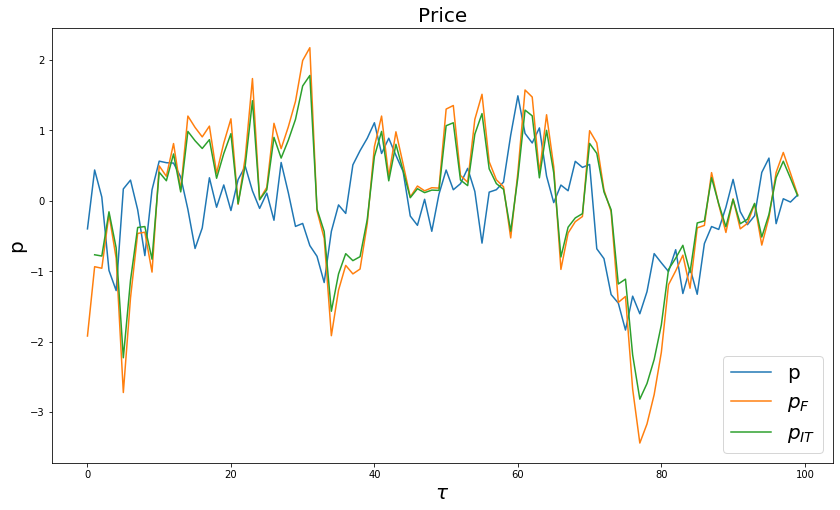

In [51]:
figure25 = plt.figure(figsize = (14,8))
plt.plot(np.arange(0,T), price_simulations[:, 1], label = "p")
plt.plot(np.arange(0,T), fundamental_price_simulations[:,1], label = r"$p_{F}$")
plt.plot(np.arange(1,T), IT_estimated_price_simulations[:,1], label = r"$p_{IT}$")
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel("p", fontsize = 20)
plt.legend(loc = 4, prop={'size': 20})
plt.title("Price", fontsize = 20)
plt.show()

**Mean return analyzer**

In [52]:
def return_mean_gain(order_flow, price_simulations, fundamental_price_simulations):
    number_of_simulations = price_simulations.shape[1]
    
    order_flow = pd.DataFrame(order_flow)
    delta_price = pd.DataFrame(price_simulations - fundamental_price_simulations )

    cash_flow = pd.DataFrame(order_flow*delta_price)
    
    avg_cash = 0
    for i in range(0,number_of_simulations):
        avg_cash += cash_flow[i][:].mean()/number_of_simulations
        
    return -1*avg_cash 

**Analyzing Agents' Gains<br/><br/>**
$\langle gain_{MM} \rangle = -\langle q_t(p_t - p^F_t) \rangle$<br/><br/>
$\langle gain_{NT} \rangle = -\langle q_t^{NT}(p_t - p^F_t) \rangle$<br/><br/>
$\langle gain_{IT} \rangle = -\langle q_t^{IT}(p_t - p^F_t) \rangle$

**Is the MM's gain really zero ? Let's run more simulations..**

In [53]:
number_of_gains = 20
list_of_MM_mean_returns = []
list_of_NT_mean_returns = []
list_of_IT_mean_returns = []
number_of_simulations = 6000

for i in range(0, number_of_gains):
    dividends_flow = generate_order_flow(ACF_MU, number_of_simulations)
    target_portfolio_order_flow = generate_order_flow(ACF_TGT, number_of_simulations)
    NT_order_flow = return_NT_order_flow(D_MU_NT, D_TGT_NT, dividends_flow, target_portfolio_order_flow)
    IT_order_flow = return_IT_order_flow(D_MU_IT, D_TGT_IT, dividends_flow, target_portfolio_order_flow)
    total_order_flow = return_total_order_flow(D_MU, D_TGT, dividends_flow, target_portfolio_order_flow)
    price_simulations = return_price_series(total_order_flow, G)
    fundamental_price_simulations = return_fundamental_price_series(dividends_flow, tau_MU)
    list_of_MM_mean_returns.append(return_mean_gain(total_order_flow, price_simulations, fundamental_price_simulations))
    list_of_NT_mean_returns.append(return_mean_gain(NT_order_flow , price_simulations, fundamental_price_simulations))
    list_of_IT_mean_returns.append(return_mean_gain(IT_order_flow , price_simulations, fundamental_price_simulations))

final_MM_mean_return =  np.mean(list_of_MM_mean_returns)
print(f"The mean of MM's gain for all simulations is {final_MM_mean_return}\n\n")

final_NT_mean_return =  np.mean(list_of_NT_mean_returns)
print(f"The mean of NT's gain for all simulations is {final_NT_mean_return}\n\n")

final_IT_mean_return =  np.mean(list_of_IT_mean_returns)
print(f"The mean of IT's gain for all simulations is {final_IT_mean_return}\n\n")

The mean of MM's gain for all simulations is -0.00047961472559240436


The mean of NT's gain for all simulations is -0.31019192213687635


The mean of IT's gain for all simulations is 0.30971230741128386




In [63]:
tau

6

**Mean Market Maker's Gain**

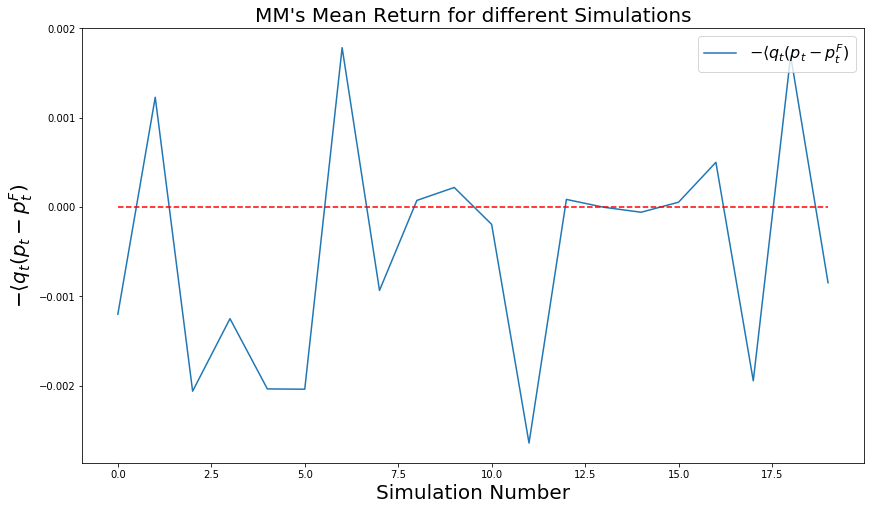

In [54]:
figure26 = plt.figure(figsize = (14,8))
plt.plot(np.arange(0,number_of_gains), list_of_MM_mean_returns, label = r"$-\langle q_t(p_t - p^F_t)$")
plt.plot(np.arange(0,number_of_gains), np.zeros(number_of_gains), color='red', linestyle='dashed',
     markerfacecolor='red')
plt.xlabel("Simulation Number", fontsize = 20)
plt.ylabel(r"$-\langle q_t(p_t - p^F_t)$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.title("MM's Mean Return for different Simulations", fontsize = 20)
plt.show()

**Mean Noise Trader's Gain**

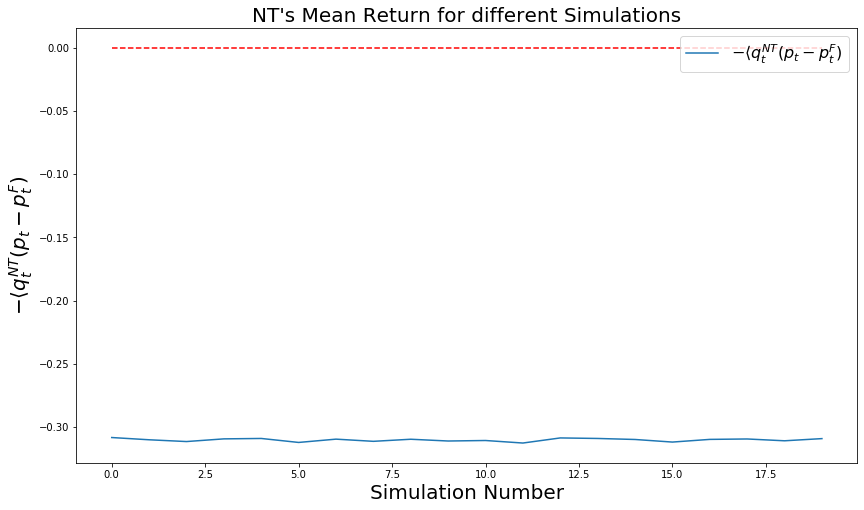

In [55]:
figure27 = plt.figure(figsize = (14,8))
plt.plot(np.arange(0,number_of_gains), list_of_NT_mean_returns, label = r"$-\langle q_t^{NT}(p_t - p^F_t)$")
plt.plot(np.arange(0,number_of_gains), np.zeros(number_of_gains), color='red', linestyle='dashed',
     markerfacecolor='red')
plt.xlabel("Simulation Number", fontsize = 20)
plt.ylabel(r"$-\langle q_t^{NT}(p_t - p^F_t)$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.title("NT's Mean Return for different Simulations", fontsize = 20)
plt.show()

**Mean Informed Trader's Gain**

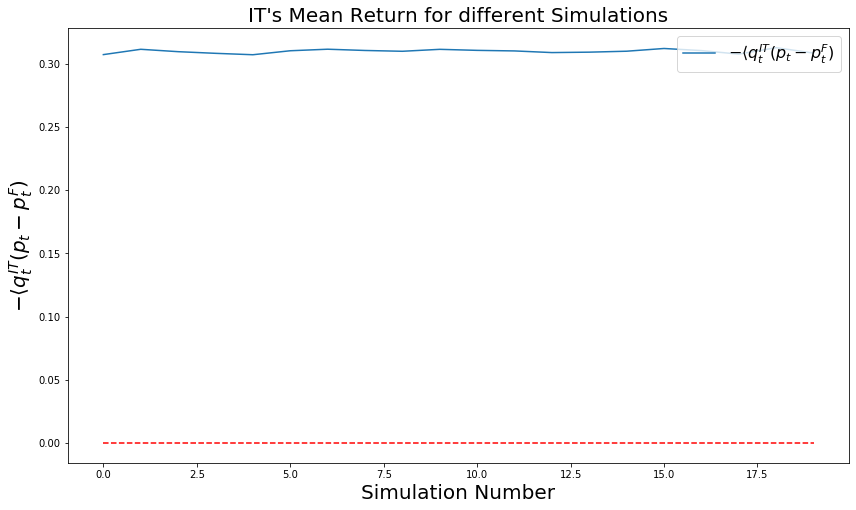

In [56]:
figure28 = plt.figure(figsize = (14,8))
plt.plot(np.arange(0,number_of_gains), list_of_IT_mean_returns, label = r"$-\langle q_t^{IT}(p_t - p^F_t)$")
plt.plot(np.arange(0,number_of_gains), np.zeros(number_of_gains), color='red', linestyle='dashed',
     markerfacecolor='red')
plt.xlabel("Simulation Number", fontsize = 20)
plt.ylabel(r"$-\langle q_t^{IT}(p_t - p^F_t)$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.title("IT's Mean Return for different Simulations", fontsize = 20)
plt.show()

## Implementing a Tracking Error Measure - $\phi_{t} =  \langle (Q_{t}^{NT} - Q_{t}^{tgt})^{2} \rangle$ 

In [57]:
def return_phi_t_and_total_positions_information(NT_order_flow, IT_order_flow, total_order_flow, target_portfolio_order_flow):
    T = NT_order_flow.shape[0]
    number_of_simulations = NT_order_flow.shape[1]
    
    phi_matrix = np.zeros((T, number_of_simulations))
    market_maker_total_position_matrix = np.zeros((T, number_of_simulations)) 
    noise_trader_total_position_matrix = np.zeros((T, number_of_simulations))
    informed_trader_total_position_matrix = np.zeros((T, number_of_simulations)) 
    target_portfolio_total_position_matrix = np.zeros((T, number_of_simulations))
    
    for i in range(0,T):
        for j in range(0, number_of_simulations):
            market_maker_total_position_matrix[i,j] = np.sum(total_order_flow[i:,j])
            informed_trader_total_position_matrix[i,j] = np.sum(IT_order_flow[i:,j]) 
            noise_trader_total_position_matrix[i,j] = np.sum(NT_order_flow[i:,j]) 
            target_portfolio_total_position_matrix[i,j] = np.sum(target_portfolio_order_flow[i:,j])
            phi_matrix[i,j] = (noise_trader_total_position_matrix[i,j] - target_portfolio_total_position_matrix[i,j])**2
    
    phi_t = np.zeros(T)
    noise_trader_total_position_t = np.zeros(T)
    target_portfolio_total_position_t = np.zeros(T)
    informed_trader_total_position_t = np.zeros(T)
    market_maker_total_position_t = np.zeros(T)
    var_noise_trader_total_position_t = np.zeros(T)
    var_target_portfolio_total_position_t = np.zeros(T)
    var_informed_trader_total_position_t = np.zeros(T)
    var_market_maker_total_position_t = np.zeros(T)
    
    for i in range(0, T):
        phi_t[i] = np.mean(phi_matrix[i,:])
        noise_trader_total_position_t[i] = np.mean(noise_trader_total_position_matrix[i,:])
        target_portfolio_total_position_t[i] = np.mean(target_portfolio_total_position_matrix[i,:])
        market_maker_total_position_t[i] = np.mean(market_maker_total_position_matrix[i, :])
        informed_trader_total_position_t[i] = np.mean(informed_trader_total_position_matrix[i,:])
        var_noise_trader_total_position_t[i] = np.var(noise_trader_total_position_matrix[i,:])
        var_target_portfolio_total_position_t[i] = np.var(target_portfolio_total_position_matrix[i,:])
        var_informed_trader_total_position_t[i] = np.var(informed_trader_total_position_matrix[i,:])
        var_market_maker_total_position_t[i] = np.var(market_maker_total_position_matrix[i, :])
        
    return phi_t[::-1], noise_trader_total_position_t[::-1], target_portfolio_total_position_t[::-1], informed_trader_total_position_t[::-1], market_maker_total_position_t[::-1], var_noise_trader_total_position_t[::-1], var_target_portfolio_total_position_t[::-1], var_informed_trader_total_position_t[::-1], var_market_maker_total_position_t[::-1]


In [58]:
def return_price_variance_t(price_series):
    T = price_series.shape[0]
    
    var_price_series_t = np.zeros(T) 
    
    for i in range(0,T):
        var_price_series_t[i] = np.var(price_series[i,:])
        
    return var_price_series_t[::-1]

**Simulating the Market for different $\alpha$**

In [255]:
def simulate_market_for_different_alphas(alpha_min, alpha_max, number_of_points, number_of_simulations):
    
    #Defining fixed parameters for the solver
    T = 100
    T_it = 100
    Var_TGT = 1
    ACF_TGT = Var_TGT*np.identity(T) ## Var_tgt is a white noise process
    G_0_seed = 1
    alpha_G = 0.5
    seed_type = "mark"
    C_NT_0 = 1
    tau_NT = 1
    C_IT_0 = 1
    tau_IT = 1
    tau = 10
    bound_for_convergence = 0.00001
    tau_MU = 5
    cte = np.exp(-1/tau_MU)
    C_MU_0 = ((1 - cte)/(cte))**2
    ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)
    
    #Lists for storing results
    alpha_vector = np.linspace(alpha_min, alpha_max, number_of_points)
    
    phi_t_vector = []
    noise_trader_total_position_t = []
    target_portfolio_total_position_t = []
    market_maker_total_position_t = []
    informed_trader_total_position_t = []
    var_noise_trader_total_position_t = []
    var_informed_trader_total_position_t = []
    var_market_maker_total_position_t = []
    var_target_portfolio_total_position_t = []
    var_price_t = []
    var_IT_estimated_price_t = []
    MM_mean_gain_vector = []
    NT_mean_gain_vector = []
    IT_mean_gain_vector = []
    ACFs_NT = []
    ACFs_IT = []
    ACFs_Q = []
    ACFs_MU = []
    ACFs_P = []
    
    for i in range(0, number_of_points):
        
        numerical_solution = numerical_solver_simulation(T, T_it, G_0_seed, alpha_G, alpha_vector[i], C_MU_0, tau_MU, ACF_TGT, seed_type, C_NT_0, 
                                tau_NT, C_IT_0, tau_IT,tau, _ , bound_for_convergence)
        
        G = numerical_solution[0]
        
        ACFs_NT.append(numerical_solution[4])
        ACFs_IT.append(numerical_solution[5])
        ACFs_Q.append(numerical_solution[6])
        ACFs_MU.append(numerical_solution[7])
        ACFs_P.append(numerical_solution[8])
        
        D_MU = numerical_solution[3][-1][0]
        D_TGT =  numerical_solution[3][-1][1]
        D_MU_NT =  numerical_solution[3][-1][2]
        D_TGT_NT =  numerical_solution[3][-1][3] 
        D_MU_IT =  numerical_solution[3][-1][4]
        D_TGT_IT =  numerical_solution[3][-1][5]
        
        dividends_flow = generate_order_flow(ACF_MU, number_of_simulations)
        target_portfolio_order_flow = generate_order_flow(ACF_TGT, number_of_simulations)
        NT_order_flow = return_NT_order_flow(D_MU_NT, D_TGT_NT, dividends_flow, target_portfolio_order_flow)
        IT_order_flow = return_IT_order_flow(D_MU_IT, D_TGT_IT, dividends_flow, target_portfolio_order_flow)
        total_order_flow = return_total_order_flow(D_MU, D_TGT, dividends_flow, target_portfolio_order_flow)
        price_simulations = return_price_series(total_order_flow, G)
        fundamental_price_simulations = return_fundamental_price_series(dividends_flow, tau_MU)
        IT_estimated_price_simulations = return_IT_estimated_price_series(dividends_flow, tau_MU)
        var_price_t.append(return_price_variance_t(price_simulations))
        var_IT_estimated_price_t.append(return_price_variance_t(IT_estimated_price_simulations))
        result_phi_and_total_positions_information = return_phi_t_and_total_positions_information(NT_order_flow, IT_order_flow, total_order_flow, target_portfolio_order_flow)
        phi_t_vector.append(result_phi_and_total_positions_information[0])
        noise_trader_total_position_t.append(result_phi_and_total_positions_information[1])
        target_portfolio_total_position_t.append(result_phi_and_total_positions_information[2])
        informed_trader_total_position_t.append(result_phi_and_total_positions_information[3])
        market_maker_total_position_t.append(result_phi_and_total_positions_information[4])
        var_noise_trader_total_position_t.append(result_phi_and_total_positions_information[5])
        var_target_portfolio_total_position_t.append(result_phi_and_total_positions_information[6])
        var_informed_trader_total_position_t.append(result_phi_and_total_positions_information[7])
        var_market_maker_total_position_t.append(result_phi_and_total_positions_information[8])
        MM_mean_gain_vector.append(return_mean_gain(total_order_flow, price_simulations, fundamental_price_simulations)) 
        NT_mean_gain_vector.append(return_mean_gain(NT_order_flow, price_simulations, fundamental_price_simulations)) 
        IT_mean_gain_vector.append(return_mean_gain(IT_order_flow, price_simulations, fundamental_price_simulations))
        
    return phi_t_vector, noise_trader_total_position_t, target_portfolio_total_position_t, informed_trader_total_position_t, market_maker_total_position_t, var_noise_trader_total_position_t, var_target_portfolio_total_position_t, var_informed_trader_total_position_t, var_market_maker_total_position_t, MM_mean_gain_vector, NT_mean_gain_vector, IT_mean_gain_vector, alpha_vector, var_price_t, var_IT_estimated_price_t, ACFs_NT, ACFs_IT, ACFs_Q, ACFs_MU, ACFs_P 

In [256]:
number_of_points = 10
market_simulation  = simulate_market_for_different_alphas(0.0001, 2, number_of_points, 6000)
phi_t_vector  = market_simulation[0] 
noise_trader_total_position_t = market_simulation[1] 
target_portfolio_total_position_t = market_simulation[2] 
informed_trader_total_position_t = market_simulation[3] 
market_maker_total_position_t = market_simulation[4] 
var_noise_trader_total_position_t = market_simulation[5] 
var_target_portfolio_total_position_t = market_simulation[6] 
var_informed_trader_total_position_t = market_simulation[7] 
var_market_maker_total_position_t = market_simulation[8] 
MM_mean_gain_vector = market_simulation[9] 
NT_mean_gain_vector = market_simulation[10] 
IT_mean_gain_vector = market_simulation[11] 
alpha_vector = market_simulation[12]
var_price_t = market_simulation[13]
var_IT_estimated_price_t = market_simulation[14]
ACFs_NT = market_simulation[15]
ACFs_IT = market_simulation[16]
ACFs_Q = market_simulation[17]
ACFs_MU = market_simulation[18]
ACFs_P = market_simulation[19]

**Plotting Tracking Error Measure Without normalization**

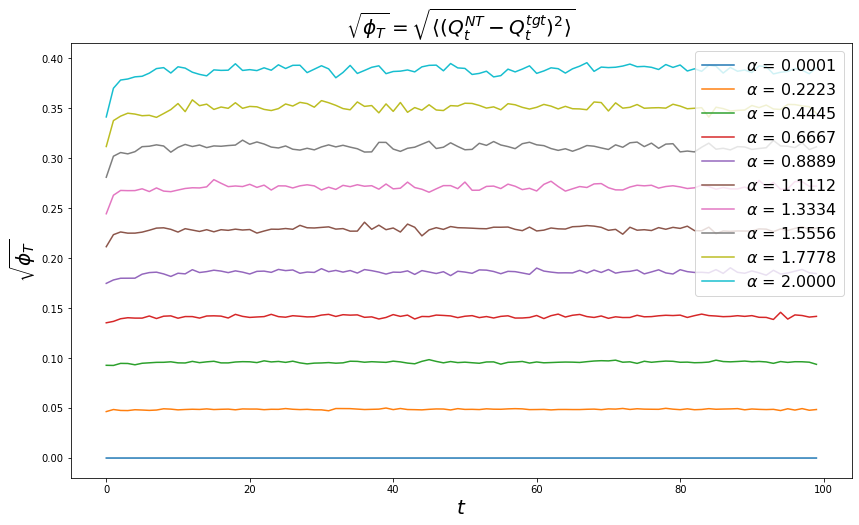

In [257]:
figure29 = plt.figure(figsize = (14,8))
plt.title(r"$\sqrt{\phi_{T}} =  \sqrt{\langle (Q_{t}^{NT} - Q_{t}^{tgt})^{2} \rangle}$ ", fontsize = 20)

for i in range (0,number_of_points):
    plt.plot(np.arange(0,len(phi_t_vector[0])), np.sqrt(phi_t_vector[i]), label = r"$\alpha$ = {:.4f}".format(alpha_vector[i]))
plt.xlabel(r"$t$", fontsize = 20)
plt.ylabel(r"$\sqrt{\phi_{T}}$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.show()

**Analyzing $\phi_{T}$ in function of $\alpha$**

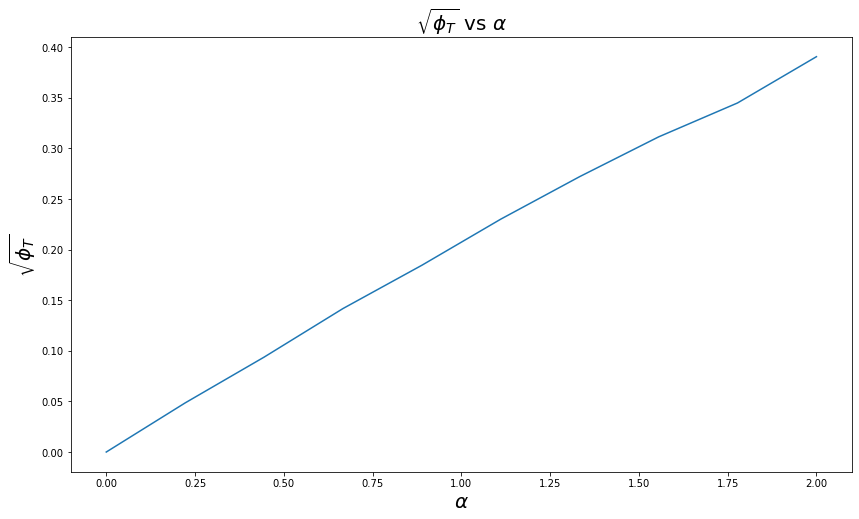

In [258]:
figure30 = plt.figure(figsize = (14,8))
plt.title(r"$\sqrt{\phi_{T}}$ vs $\alpha$", fontsize = 20)

phi_stationary_sqrt = []

for i in range(number_of_points):
    phi_stationary_sqrt.append(np.sqrt(phi_t_vector[i][-1]))
    

plt.plot(alpha_vector, phi_stationary_sqrt)

plt.xlabel(r"$\alpha$", fontsize = 20)
plt.ylabel(r"$\sqrt{\phi_{T}}$", fontsize = 20)
plt.show()

**Analyzing the Mean Gain of the Traders vs $\sqrt{\phi_{T}}$**

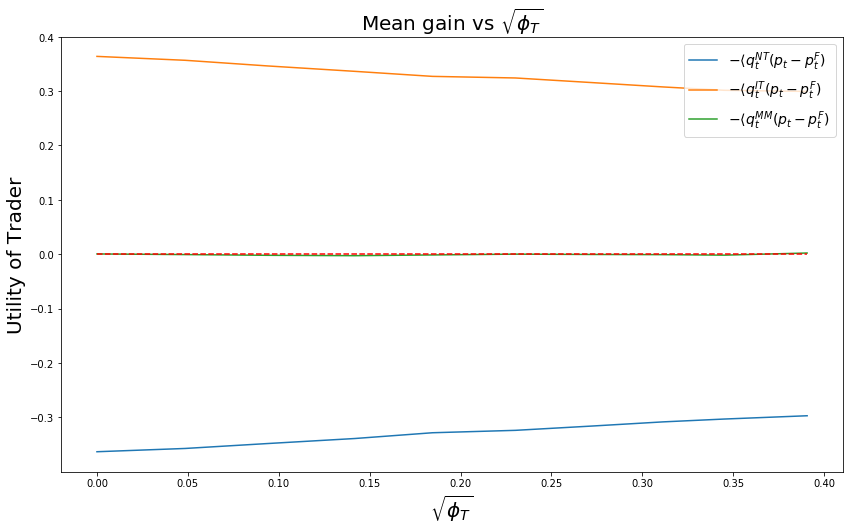

In [259]:
figure31 = plt.figure(figsize = (14,8))
plt.title(r"Mean gain vs $\sqrt{\phi_{T}}$", fontsize = 20)
plt.plot(phi_stationary_sqrt, NT_mean_gain_vector, label = r"$-\langle q_t^{NT}(p_t - p^F_t)$" )
plt.plot(phi_stationary_sqrt, IT_mean_gain_vector, label = r"$-\langle q_t^{IT}(p_t - p^F_t)$")
plt.plot(phi_stationary_sqrt, MM_mean_gain_vector, label = r"$-\langle q_t^{MM}(p_t - p^F_t)$")
plt.plot(phi_stationary_sqrt, np.zeros(len(phi_stationary_sqrt)), color='red', linestyle='dashed',
     markerfacecolor='red')
plt.xlabel(r"$\sqrt{\phi_{T}}$", fontsize = 20)
plt.ylabel(r"Utility of Trader", fontsize = 20)
plt.legend(loc = 1, prop={'size': 14})
plt.show()

## Studying Price Movements

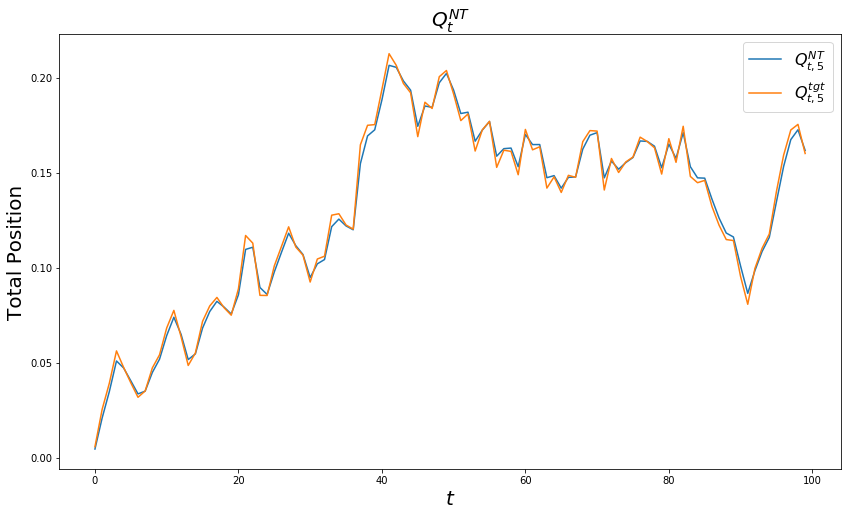

In [260]:
figure32 = plt.figure(figsize = (14,8))
plt.title(r"$Q_{t}^{NT}$ ", fontsize = 20)

for i in range (5,6):
    plt.plot(np.arange(0,len(phi_t_vector[0])), noise_trader_total_position_t[i], label = r"$Q_{{t,{}}}^{{NT}}$".format(i))
    plt.plot(np.arange(0,len(phi_t_vector[0])), target_portfolio_total_position_t[i], label = r"$Q_{{t,{}}}^{{tgt}}$".format(i))

plt.xlabel(r"$t$", fontsize = 20)
plt.ylabel(r"Total Position", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.show()

## Studying Total Position's Properties

**Noise trader's total position and Target Portfolio's total position - $Q_{t}^{NT} \ \& \ Q_{t}^{tgt}$**

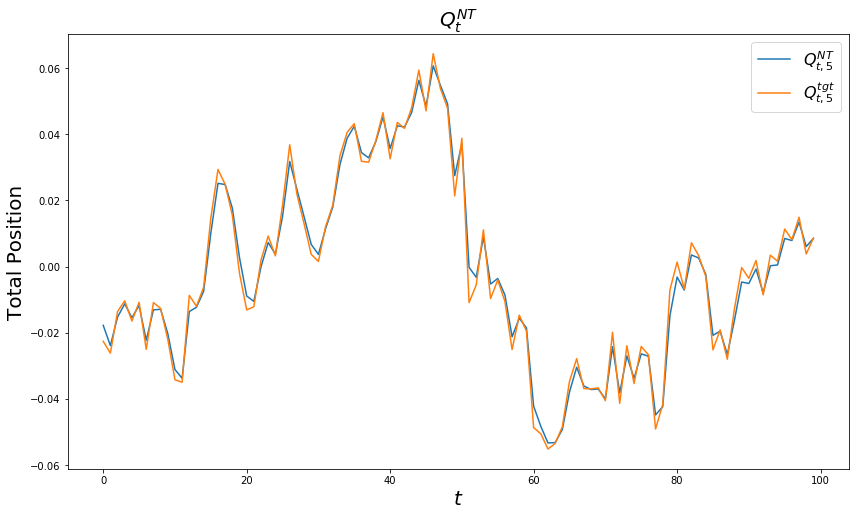

In [94]:
figure33 = plt.figure(figsize = (14,8))
plt.title(r"$Q_{t}^{NT}$ ", fontsize = 20)

for i in range (5,6):
    plt.plot(np.arange(0,len(phi_t_vector[0])), noise_trader_total_position_t[i], label = r"$Q_{{t,{}}}^{{NT}}$".format(i))
    plt.plot(np.arange(0,len(phi_t_vector[0])), target_portfolio_total_position_t[i], label = r"$Q_{{t,{}}}^{{tgt}}$".format(i))

plt.xlabel(r"$t$", fontsize = 20)
plt.ylabel(r"Total Position", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.show()

**Investigating the Variance of Total Positions** <br/><br/>
$ Var_{(Q_{MM})}  = \langle Q_{MM}^{2} \rangle$<br/><br/>
$ Var_{(Q_{NT})}  = \langle Q_{NT}^{2} \rangle$<br/><br/>
$ Var_{(Q_{IT})} = \langle Q_{IT}^{2} \rangle $

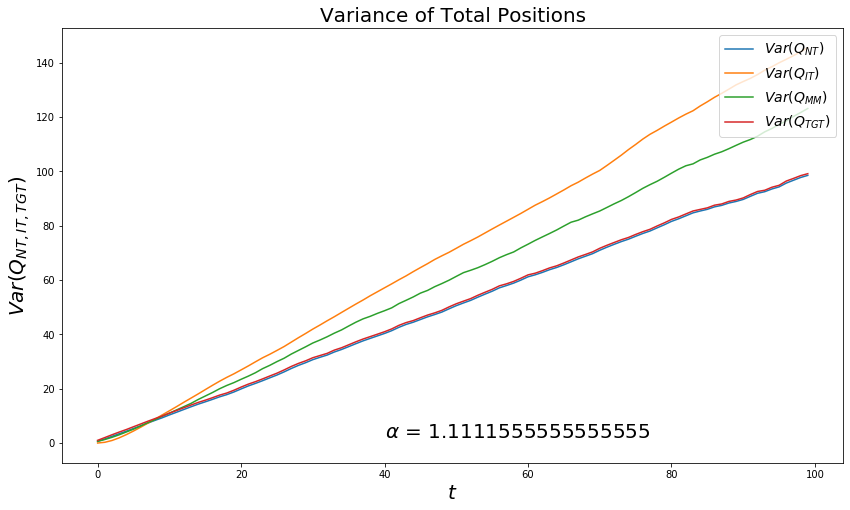

In [261]:
figure33 = plt.figure(figsize = (14,8))
plt.title(r"Variance of Total Positions", fontsize = 20)

for i in range (5,6):
    plt.plot(np.arange(0,len(phi_t_vector[0])), var_noise_trader_total_position_t[i], label = r"$Var(Q_{NT})$")
    plt.plot(np.arange(0,len(phi_t_vector[0])), var_informed_trader_total_position_t[i], label = r"$Var(Q_{IT})$")
    plt.plot(np.arange(0,len(phi_t_vector[0])), var_market_maker_total_position_t[i], label = r"$Var(Q_{MM})$")
    plt.plot(np.arange(0,len(phi_t_vector[0])), var_target_portfolio_total_position_t[i], label = r"$Var(Q_{TGT})$")
    plt.text(40,2,r"$\alpha$ = {}".format(alpha_vector[i]), fontsize = 20)
plt.xlabel(r"$t$", fontsize = 20)
plt.ylabel(r"$Var(Q_{NT,IT,TGT})$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 14})
plt.show()

**Investigating the Variance of Price Series** <br/><br/>
$ Var_{p}  = \langle p^{2} \rangle$<br/><br/>
$ Var_{p^{IT}}  = \langle (p^{IT})^{2} \rangle$<br/><br/>

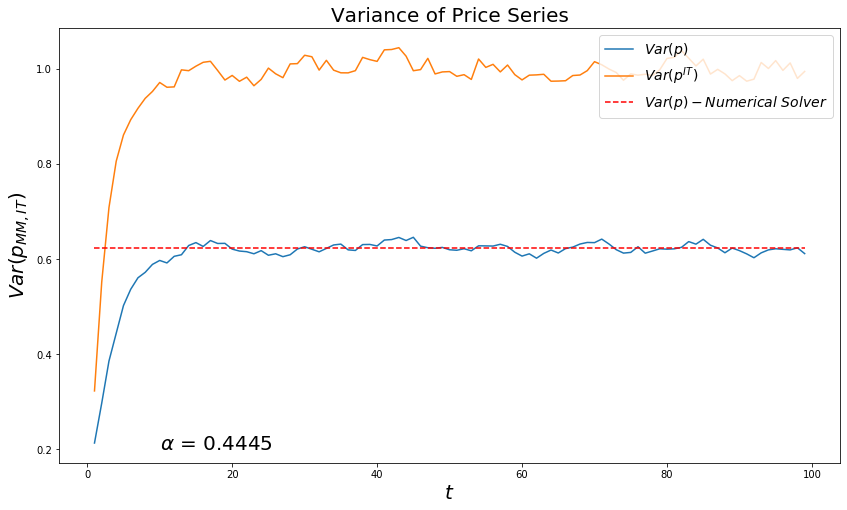

In [262]:
figure34 = plt.figure(figsize = (14,8))
plt.title(r"Variance of Price Series", fontsize = 20)

for i in range (2,3):
    plt.plot(np.arange(1,len(phi_t_vector[0])), var_price_t[i][1:], label = r"$Var(p)$")
    plt.plot(np.arange(1,len(phi_t_vector[0])), var_IT_estimated_price_t[i], label = r"$Var(p^{IT})$")
    plt.plot(np.arange(1,len(phi_t_vector[0])),np.ones(len(phi_t_vector[0]) - 1)*ACFs_P[i][0,0], label = r"$Var(p) - Numerical \ Solver$", linestyle = 'dashed', color = 'r')
    plt.text(10,0.2,r"$\alpha$ = {:.4f}".format(alpha_vector[i]), fontsize = 20)
plt.xlabel(r"$t$", fontsize = 20)
plt.ylabel(r"$Var(p_{MM,IT})$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 14})
plt.show()

**Ratio of Variances in function of time**</br></br>

$Var(Q_{NT})_{T}/Var(Q_{TGT})_{T}$ as function of $\sqrt{\phi_{T}}$<br/><br/>

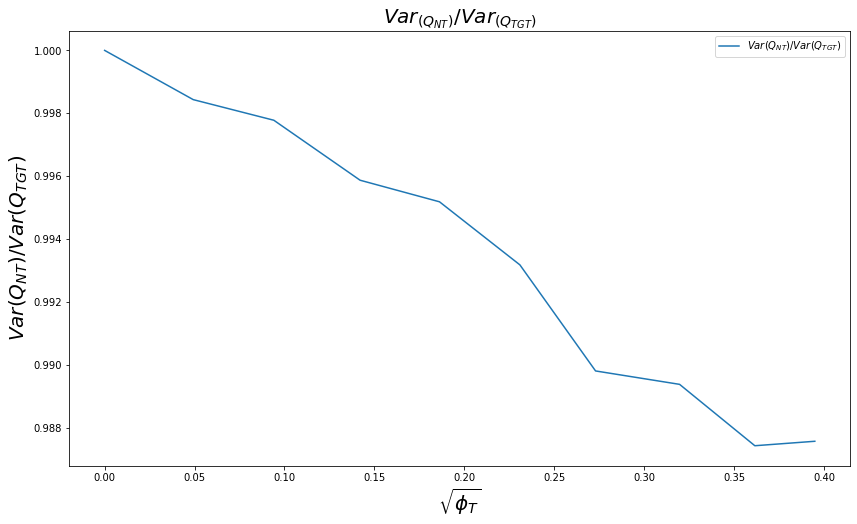

In [99]:
figure35 = plt.figure(figsize = (14,8))
plt.title(r"$ Var_{(Q_{NT})}/Var_{(Q_{TGT})}$", fontsize = 20)

ratio_var_nt_tgt_stationary = []
ratio_var_nt_tgt_stationary_numerical_solver = []

for i in range(0, number_of_points):
    ratio_var_nt_tgt_stationary.append((var_noise_trader_total_position_t[i]/var_target_portfolio_total_position_t[i])[-1])
    #ratio_var_nt_tgt_stationary_numerical_solver.append(ACFs_NT[i][-1][0,0])

plt.plot(phi_stationary_sqrt, ratio_var_nt_tgt_stationary, label = r"$Var(Q_{{NT}})/Var(Q_{{TGT}})$")
#plt.plot(phi_stationary_sqrt, ratio_var_nt_tgt_stationary_numerical_solver, label = r"$Var(Q_{{NT}})/Var(Q_{{TGT}}) - Numerical \ Solver$")
plt.xlabel(r"$\sqrt{\phi_{T}}$", fontsize = 20)
plt.ylabel(r"$Var(Q_{NT})/Var(Q_{TGT})$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 10})
plt.show()

$Var_{(Q_{MM})}/Var_{(Q_{NT})}$ as function of $\sqrt{\phi_{T}}$<br/><br/>

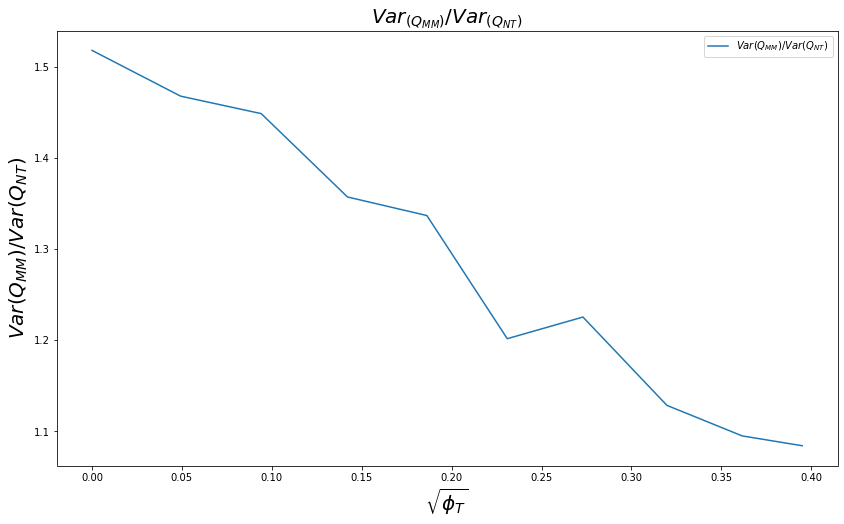

In [100]:
figure35 = plt.figure(figsize = (14,8))
plt.title(r"$ Var_{(Q_{MM})}/Var_{(Q_{NT})}$", fontsize = 20)

ratio_var_mm_nt_stationary = []

for i in range(0, number_of_points):
    ratio_var_mm_nt_stationary.append((var_market_maker_total_position_t[i]/var_noise_trader_total_position_t[i])[-1])


plt.plot(phi_stationary_sqrt, ratio_var_mm_nt_stationary, label = r"$Var(Q_{{MM}})/Var(Q_{{NT}})$")
plt.xlabel(r"$\sqrt{\phi_{T}}$", fontsize = 20)
plt.ylabel(r"$Var(Q_{MM})/Var(Q_{NT})$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 10})
plt.show()

**Informational Market Efficiency**<br/><br/>
$Var_{(p)}/Var_{(p^{IT})}$ as function of $\sqrt{\phi_{T}}$<br/><br/>

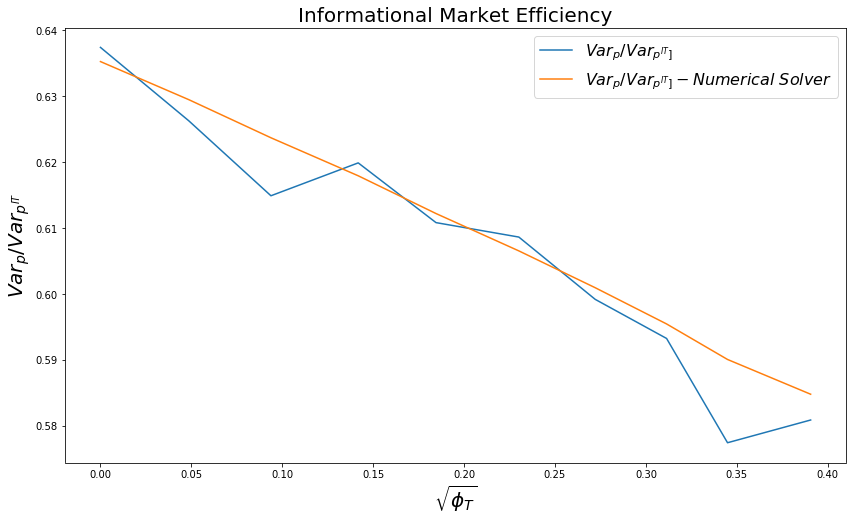

In [263]:
figure35 = plt.figure(figsize = (14,8))
plt.title("Informational Market Efficiency", fontsize = 20)

ratio_var_p_pt_it_stationary = []
ratio_var_p_pt_it_stationary_numerical_solver = []


for i in range(0, number_of_points):
    ratio_var_p_pt_it_stationary.append((var_price_t[i][-1]/var_IT_estimated_price_t[i])[-1])
    ratio_var_p_pt_it_stationary_numerical_solver.append(ACFs_P[i][0,0])


plt.plot(phi_stationary_sqrt, ratio_var_p_pt_it_stationary, label = r"$ Var_{p}/Var_{p^{IT}]}$")
plt.plot(phi_stationary_sqrt, ratio_var_p_pt_it_stationary_numerical_solver, label = r"$ Var_{p}/Var_{p^{IT}]} - Numerical \ Solver$")
plt.xlabel(r"$\sqrt{\phi_{T}}$", fontsize = 20)
plt.ylabel(r"$ Var_{p}/Var_{{p^{IT}}}$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.show()

## Analyzing the order flow relative to impact - $q_{G}^{NT}$ and $q_{G}^{IT}$

**Functions to return mean flow**

In [35]:
def return_order_flow_impact_NT(NT_order_flow, target_portfolio_order_flow):     
    return NT_order_flow - target_portfolio_order_flow 

In [36]:
def return_mean_price_series(price_simulations):
    T = price_simulations.shape[0]
    mean_price_series = np.zeros((T,1))
    
    for i in range(0,T):
        mean_price_series[i,0] = np.mean(price_simulations[i,:])
        
    return mean_price_series

In [37]:
def return_mean_NT_order_flow(NT_order_flow):
    T = NT_order_flow.shape[0]
    mean_NT_order_flow = np.zeros((T,1))
    
    for i in range(0,T):
        mean_NT_order_flow [i,0] = np.mean(NT_order_flow[i,:])
        
    return mean_NT_order_flow

In [38]:
def return_mean_target_portfolio_order_flow(target_portfolio_order_flow):
    T = target_portfolio_order_flow.shape[0]
    mean_target_portfolio_order_flow = np.zeros((T,1))
    
    for i in range(0,T):
        mean_target_portfolio_order_flow[i,0] = np.mean(target_portfolio_order_flow[i,:])
        
    return mean_target_portfolio_order_flow

**Evaluating Impact Flow**

In [108]:
order_flow_impact_NT = return_order_flow_impact_NT(NT_order_flow, target_portfolio_order_flow)

**We have that:<br/>**

$q_{G}^{NT}(t) = q_{G}^{NT}(t) - q_{G}^{tgt}(t)$

**And: <br/>**

$ \langle q_{t}^{NT}q_{t + \tau}^{NT} \rangle = \langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle + \langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle + \langle   q_{G_{ t }}^{NT}q_{G_{ t + \tau}}^{NT} \rangle  + \langle   q_{t}^{tgt}q_{t+\tau}^{tgt} \rangle  $

**Verifying  $\langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle$**

In [39]:
def return_cross_product_impact_target(order_flow_impact_NT, target_portfolio_order_flow):
    number_of_lags = order_flow_impact_NT.shape[0]
    number_of_simulations = order_flow_impact_NT.shape[1] 
    cross_products_for_tau = np.zeros((T,number_of_simulations))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau[tau] = order_flow_impact_NT[0,:]*target_portfolio_order_flow[tau,:]
    
    cross_products_for_tau_mean = np.zeros((T,1))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau_mean[tau] = np.mean(cross_products_for_tau[tau,:])
         
    return cross_products_for_tau_mean

**Cross product from simulations**

In [110]:
cross_product_impact_target = return_cross_product_impact_target(order_flow_impact_NT, target_portfolio_order_flow)

**Deterministic cross product obtained from numerical solver data**

In [111]:
I = np.identity(T)
deterministic_cross_product_impact_target = np.matmul((D_TGT_NT - I),ACF_TGT)

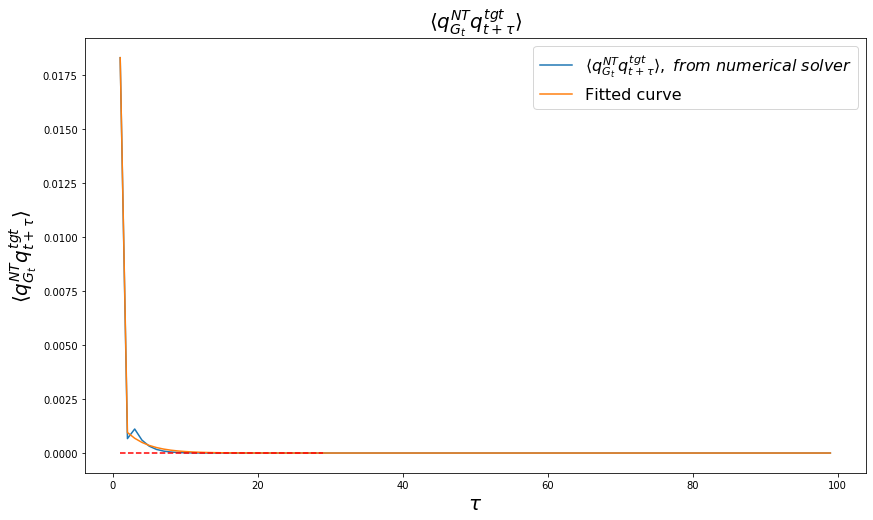

In [119]:
figure36 = plt.figure(figsize = (14,8))
plt.title(r"$\langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle$", fontsize = 20)

#plt.plot(np.arange(20,90), cross_product_impact_target[:20], label = r"$\langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle, \ from \ simulation$")
plt.plot(np.arange(1, 100), deterministic_cross_product_impact_target[0,1:100], label = r"$\langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle, \ from \ numerical \ solver$")
plt.plot(x_1,sum_exp(x_1, parameters_1[0], parameters_1[1], parameters_1[2], parameters_1[3]), label = "Fitted curve")
plt.plot(np.arange(1,30), np.zeros(29), linestyle = 'dashed', color = 'r')
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$\langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
#plt.yscale('log')
plt.show()

**Fit for finding the timescale**

In [118]:
from scipy.optimize import curve_fit
y_1 = deterministic_cross_product_impact_target[0,1:]
x_1 = np.arange(1,100)
def sum_exp(x, a, b, tau_1, tau_2):
    return a*np.exp(-x_1/tau_1) + b*np.exp(-x_1/tau_2)
parameters_1, cov = curve_fit(f = sum_exp, xdata = x_1, ydata = y_1, p0 = [1,1,1,1], maxfev= 50000)

**Sum of squares error**

In [120]:
error = (y_1 - sum_exp(x_1, *parameters_1))**2
print(np.sum(error))

3.117372170733017e-07


$\tau_{ q_{G_{t}}^{NT} q_{t + \tau}^{tgt}}$

In [121]:
parameters_1

array([1.83848337e-03, 5.95962380e+04, 3.03286139e+00, 6.63544935e-02])

**Verifying $\langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle$**

In [122]:
def return_cross_product_target_impact(order_flow_impact_NT, target_portfolio_order_flow):
    number_of_lags = order_flow_impact_NT.shape[0]
    number_of_simulations = order_flow_impact_NT.shape[1] 
    cross_products_for_tau = np.zeros((T,number_of_simulations))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau[tau] = target_portfolio_order_flow[0,:]*order_flow_impact_NT[tau,:]
    
    cross_products_for_tau_mean = np.zeros((T,1))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau_mean[tau] = np.mean(cross_products_for_tau[tau,:])
         
    return cross_products_for_tau_mean

**Cross product from simulations**

In [124]:
cross_product_target_impact = return_cross_product_target_impact(order_flow_impact_NT, target_portfolio_order_flow)

**Deterministic cross product obtained from numerical solver data**

In [125]:
deterministic_cross_product_target_impact = np.matmul(ACF_TGT, (D_TGT_NT.T - I))

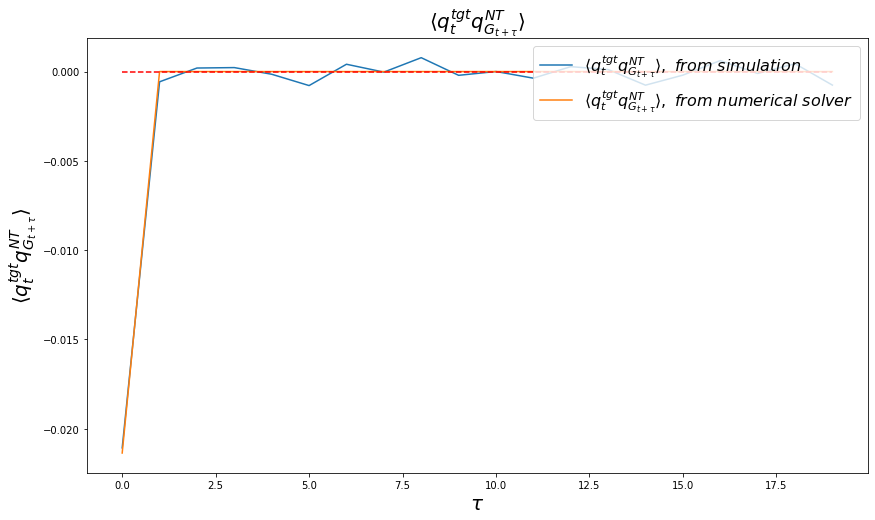

In [126]:
figure37 = plt.figure(figsize = (14,8))
plt.title(r"$\langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle$", fontsize = 20)

plt.plot(np.arange(0,20), cross_product_target_impact[:20], label = r"$\langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle, \ from \ simulation$")
plt.plot(np.arange(0,20), deterministic_cross_product_target_impact[0,:20], label = r"$\langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle, \ from \ numerical \ solver$")
plt.plot(np.arange(0,20), np.zeros(20), linestyle = 'dashed', color = 'r')
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$\langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 16})
plt.show()

**Delta contribution at lag**

In [127]:
deterministic_cross_product_target_impact[0,0]

-0.021363919526684927

**Verifying $\langle   q_{G_{ t }}^{NT}q_{G_{ t + \tau}}^{NT} \rangle$**

In [128]:
def return_cross_product_impact_impact(order_flow_impact_NT):
    number_of_lags = order_flow_impact_NT.shape[0]
    number_of_simulations = order_flow_impact_NT.shape[1] 
    cross_products_for_tau = np.zeros((T,number_of_simulations))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau[tau] = order_flow_impact_NT[0,:]*order_flow_impact_NT[tau,:]
    
    cross_products_for_tau_mean = np.zeros((T,1))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau_mean[tau] = np.mean(cross_products_for_tau[tau,:])
         
    return cross_products_for_tau_mean

**Cross product from simulations**

In [129]:
cross_product_impact_impact = return_cross_product_impact_impact(order_flow_impact_NT)

**Deterministic cross product obtained from numerical solver data**

In [130]:
deterministic_cross_product_impact_impact = np.matmul(D_MU_NT, np.matmul(ACF_MU, D_MU_NT.T)) + np.matmul((D_TGT_NT - I), np.matmul(ACF_TGT, (D_TGT_NT.T - I)))

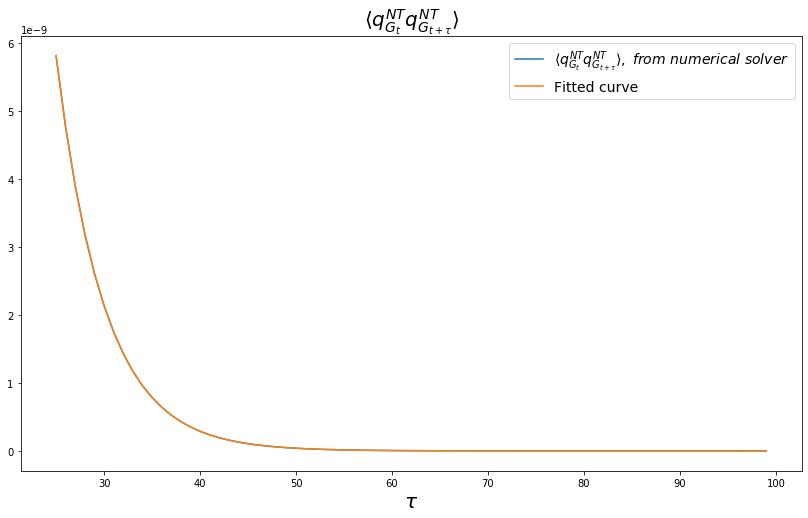

In [144]:
figure38 = plt.figure(figsize = (14,8))
plt.title(r"$\langle q_{G_{ t }}^{NT} q_{G_{ t + \tau}}^{NT} \rangle$", fontsize = 20)
plt.plot(np.arange(25,100), -1*deterministic_cross_product_impact_impact[0,25:100], label = r"$\langle q_{G_{ t }}^{NT} q_{G_{ t + \tau}}^{NT} \rangle, \ from \ numerical \ solver$")
plt.plot(x_2,exp(x_2, parameters_2[0], parameters_2[1]), label = "Fitted curve")
#plt.plot(np.arange(20,90), np.zeros(70), linestyle = 'dashed', color = 'r')
plt.xlabel(r"$\tau$", fontsize = 20)
#plt.ylabel(r"$\langle q_{G_{ t }}^{NT} q_{G_{ t + \tau}}^{NT} \rangle$", fontsize = 20)
plt.legend(loc = 1, prop={'size': 14})
#plt.yscale('log')
plt.show()

**Fit for finding the timescale**

In [142]:
from scipy.optimize import curve_fit
y_2 = -1*deterministic_cross_product_impact_impact[0,25:100]
x_2 = np.arange(25,100)
def exp(x_2, a, tau):
    return a*np.exp(-x_2/tau)
parameters_2, cov = curve_fit(f = exp, xdata = x_2, ydata = y_2, p0 = [1,1])

**Fit with a delta contribution + two exponentials**

In [139]:
from scipy.optimize import curve_fit
y_2 = deterministic_cross_product_impact_impact[0,0:100]
x_2 = np.arange(0,100)
def sum_delta_exp(x_2, a, b, tau_1, tau_2, delta_amplitude):
    return a*np.exp(-x_2/tau_1) +  b*np.exp(-x_2/tau_2) + delta_amplitude*delta_vector(len(x_2))
parameters_2, cov = curve_fit(f = sum_delta_exp, xdata = x_2, ydata = y_2, p0 = [1, 1, 1, 1, 1], maxfev = 50000)

**Sum of squares error**

In [145]:
error = (y_2 - exp(x_2, *parameters_2))**2
print(np.sum(error))

1.6487289375925384e-23


**Verifying $\langle   q_{t}^{tgt}q_{t+\tau}^{tgt} \rangle$** 

In [146]:
def return_cross_product_target_target(target_portfolio_order_flow):
    number_of_lags = target_portfolio_order_flow.shape[0]
    number_of_simulations = target_portfolio_order_flow.shape[1] 
    cross_products_for_tau = np.zeros((T,number_of_simulations))
    
    for tau in range(0,number_of_lags):
        cross_products_for_tau[tau] = target_portfolio_order_flow[0,:]*target_portfolio_order_flow[tau,:]
    
    cross_products_for_tau_mean = np.zeros((T,1))
    for tau in range(0,number_of_lags):
        cross_products_for_tau_mean[tau] = np.mean(cross_products_for_tau[tau,:])
         
    return cross_products_for_tau_mean

**Cross product from simulations**

In [147]:
cross_product_target_target = return_cross_product_target_target(target_portfolio_order_flow)

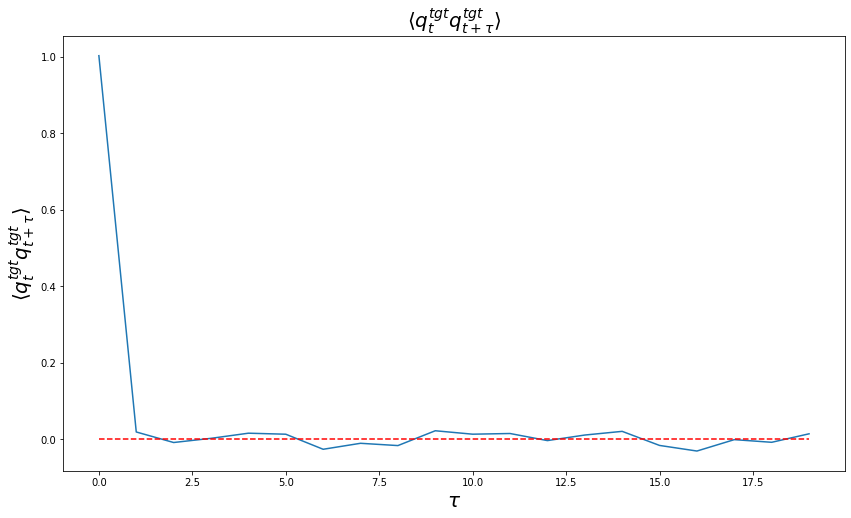

In [148]:
figure39 = plt.figure(figsize = (14,8))
plt.title(r"$\langle   q_{t}^{tgt}q_{t+\tau}^{tgt} \rangle$", fontsize = 20)

plt.plot(np.arange(0,20), cross_product_target_target[:20])
plt.plot(np.arange(0,20), np.zeros(20), linestyle = 'dashed', color = 'r')
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$\langle   q_{t}^{tgt}q_{t+\tau}^{tgt} \rangle$", fontsize = 20)
plt.show()

**Checking the consistency equation from simulation, this is: <br/>**

$ \langle q_{t}^{NT}q_{t + \tau}^{NT} \rangle = \langle q_{t}^{tgt}q_{G_{ t + \tau}}^{NT} \rangle + \langle   q_{G_{t}}^{NT} q_{t + \tau}^{tgt} \rangle + \langle   q_{G_{ t }}^{NT}q_{G_{ t + \tau}}^{NT} \rangle  + \langle   q_{t}^{tgt}q_{t+\tau}^{tgt} \rangle  $

In [150]:
right_hand_side = cross_product_impact_target + cross_product_target_impact + cross_product_impact_impact + cross_product_target_target 

In [151]:
left_hand_side = return_mean_ACF(pd.DataFrame(NT_order_flow), T, number_of_simulations)

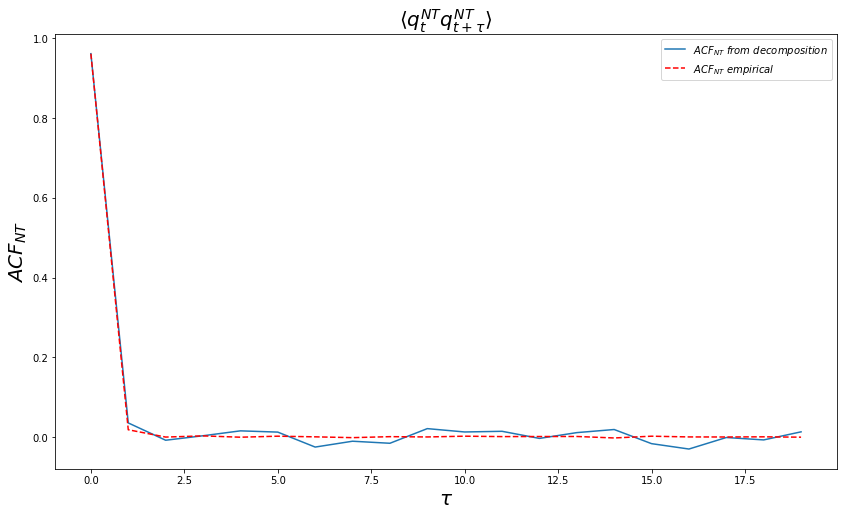

In [153]:
figure40 = plt.figure(figsize = (14,8))
plt.title(r"$\langle   q_{t}^{NT}q_{t+\tau}^{NT} \rangle$", fontsize = 20)
plt.plot(np.arange(0,20), right_hand_side[:20], label = r"$ACF_{NT} \ from \ decomposition$")
plt.plot(np.arange(0,20), left_hand_side[:20], linestyle = 'dashed', color = 'r', label = r"$ACF_{NT} \ empirical$")
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{NT}$", fontsize = 20)
plt.legend()
plt.show()

**Trying to fit $G$ as $\delta_{0} + exp$**

In [155]:
from scipy.optimize import curve_fit
y_G = G[0,0:100]
x_G = np.arange(0,100)
def delta_exp(x_G, a, tau, delta_amplitude):
    return a*np.exp(-x_G/tau) + delta_amplitude*delta_vector(len(x_G))
parameters_G, cov = curve_fit(f = delta_exp, xdata = x_G, ydata = y_G, p0 = [1,1,1], maxfev = 50000)

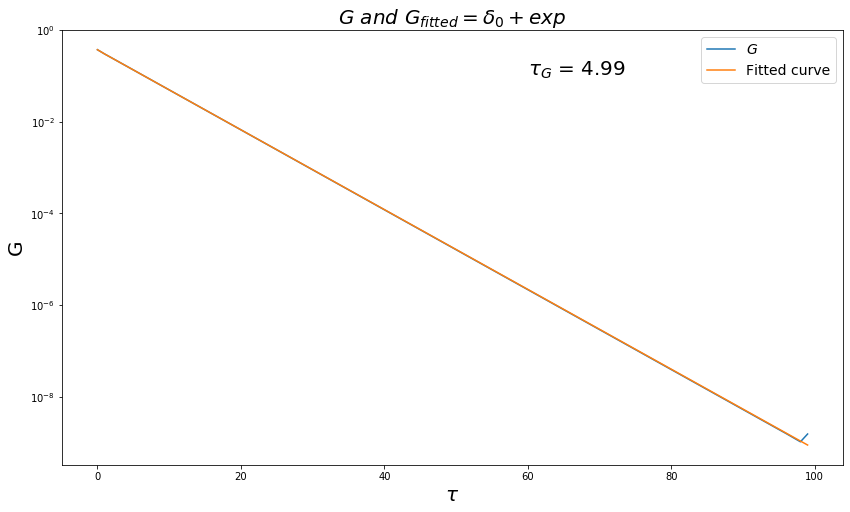

In [163]:
figure40 = plt.figure(figsize = (14,8))
plt.title(r"$G \ and \ G_{fitted} = \delta_{0} + exp$", fontsize = 20)
plt.plot(np.arange(0,100), G[0,0:100], label = r"$G$")
plt.plot(x_G,delta_exp(x_G, parameters_G[0], parameters_G[1], parameters_G[2]), label = "Fitted curve")
#plt.plot(np.arange(20,90), np.zeros(70), linestyle = 'dashed', color = 'r')
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"G", fontsize = 20)
plt.text(60,0.1,r"$\tau_{{G}}$ = {:.2f}".format(parameters_G[1]), fontsize = 20)
plt.legend(loc = 1, prop={'size': 14})
plt.yscale('log')
plt.show()

In [164]:
parameters_G

array([3.67798082e-01, 4.98956496e+00, 4.89893882e-03])

**Trying to fit the $ACF_{NT}$ with curve fit**

In [166]:
from scipy.optimize import curve_fit
y_3 = ACF_NT
x_3 = np.arange(0,100)
def delta_sum_exp(x_3, a, b, c, tau_1, tau_2, delta_magnitude):
    return delta_magnitude*delta_vector(len(x_3)) + a*np.exp(-x_3/tau_1) + b*np.exp(-x_3/tau_2) + c*np.exp(-x_3/5)
parameters_3, cov = curve_fit(f = delta_sum_exp, xdata = x_3, ydata = y_3, p0 = [1,1,1,1,1,1], maxfev = 50000)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


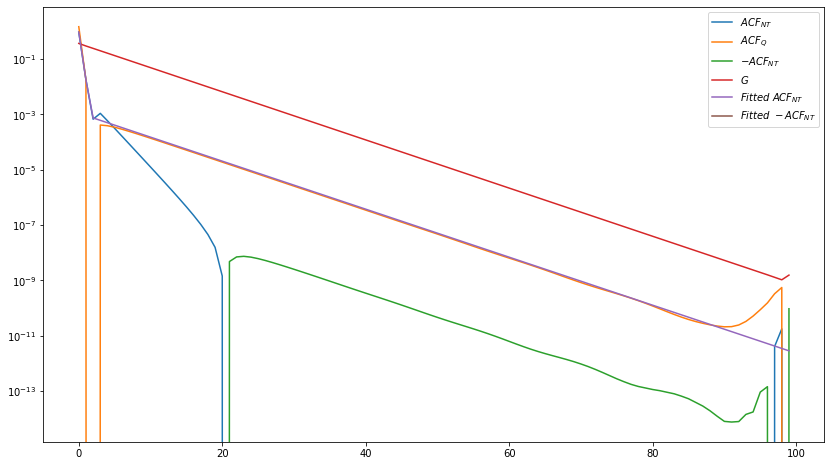

In [172]:
figure40 = plt.figure(figsize = (14,8))
plt.plot(np.arange(0,100), ACF_NT, label = r"$ACF_{NT}$")
plt.plot(np.arange(0,100), ACF_Q, label = r"$ACF_{Q}$")
plt.plot(np.arange(0,100), -1*ACF_NT, label = r"$-ACF_{NT}$")
plt.plot(np.arange(0,100), G[0,:], label = r"$G$")
plt.plot(x_3,delta_sum_exp(x_3, parameters_3[0], parameters_3[1], parameters_3[2], parameters_3[3], parameters_3[4], parameters_3[5] ), label = r"$Fitted \ ACF_{NT}$")
plt.plot(x_3,-1*delta_sum_exp(x_3, parameters_3[0], parameters_3[1], parameters_3[2], parameters_3[3], parameters_3[4], parameters_3[5]), label = "$Fitted \ - ACF_{NT}$")
plt.yscale('log')
plt.legend()

**Sum of squares error**

In [173]:
error = (y_3 - delta_sum_exp(x_3, *parameters_3))**2
print(np.sum(error))

4.45210135890804e-07


In [174]:
parameters_3

array([-2.15220134e+03,  4.64193586e+03,  1.11972986e-03,  4.00204283e-03,
        7.98950334e-02, -2.48877758e+03])

**Trying to fit $ACF_{NT}$ as the sum of the others fits**

In [ ]:
fit_cross_product_impact_impact = 

## Is the correlation timescales' properties robust ?

In [175]:
T = 100
T_it = 100
G_0_seed = 1
alpha_G = 0.5
seed_type = "mark"
C_NT_0 = 1
tau_NT = 1
C_IT_0 = 1
tau_IT = 1
tau = 5
bound_for_convergence = 0.00001


Var_TGT = 1
ACF_TGT = Var_TGT*np.identity(T) ## Var_tgt is a white noise process

I = np.identity(T)

tau_MU_min = 1
tau_MU_max = 7

alpha_min = 0.1
alpha_max = 1.5

number_of_points = 3

alpha_vector = np.linspace(alpha_min, alpha_max, number_of_points)
tau_MU_vector = np.linspace(tau_MU_min, tau_MU_max, number_of_points)


D_MUs = []
D_TGTs = []
D_MU_NTs = []
D_TGT_NTs = []
D_MU_ITs = []
D_TGT_ITs = []
ACFs_NT = []
ACFs_Q = []
Gs = []
ACFs_MU = []

for i in range(0, number_of_points*number_of_points):
    cte = np.exp(-1/tau_MU_vector[i%number_of_points])
    C_MU_0 = ((1 - cte)/(cte))**2
    ACFs_MU.append(return_Markovian_ACF(C_MU_0, tau_MU_vector[i%number_of_points], T))

In [176]:
for i in range(0, number_of_points):
    for j in range(0, number_of_points):
    
        cte = np.exp(-1/tau_MU_vector[i])
        C_MU_0 = ((1 - cte)/(cte))**2
    
        numerical_solution = numerical_solver_simulation(T, T_it, G_0_seed, alpha_G, alpha_vector[i], C_MU_0, tau_MU_vector[j], ACF_TGT, seed_type, C_NT_0, 
                            tau_NT, C_IT_0, tau_IT, tau, _ , bound_for_convergence)

        D_MU = numerical_solution[3][-1][0]
        D_TGT =  numerical_solution[3][-1][1]
        D_MU_NT =  numerical_solution[3][-1][2]
        D_TGT_NT =  numerical_solution[3][-1][3] 
        D_MU_IT =  numerical_solution[3][-1][4]
        D_TGT_IT =  numerical_solution[3][-1][5]
    
        D_MUs.append(D_MU)
        D_TGTs.append(D_TGT)
        D_MU_NTs.append(D_MU_NT)
        D_TGT_NTs.append(D_TGT_NT)
        D_MU_ITs.append(D_MU_IT)
        D_TGT_ITs.append(D_TGT_IT)
        ACFs_NT.append(numerical_solution[4][-1][0,:])
        ACFs_Q.append(numerical_solution[6][-1][0,:])
        Gs.append(numerical_solution[2][-1])
    
        print(f"Finished test {i*number_of_points + j + 1}")

Finished test 1
Finished test 2
Finished test 3
Finished test 4
Finished test 5
Finished test 6
Finished test 7
Finished test 8
Finished test 9


**Generating impact order flow ACF for different $\alpha$ and $\tau_{\mu}$ values - Evaluation of $\tau_{GG}$ (lags >= 25)**

In [197]:
deterministic_cross_products_impact_impact = []
taus_GG = []

from scipy.optimize import curve_fit

seeds = np.zeros(2)

seeds[0] = 1
seeds[1] = 1

def exp(x, a, tau):
    return a*np.exp(-x/tau)

x = np.arange(25,T)

for i in range(0, number_of_points*number_of_points):
    deterministic_cross_products_impact_impact.append(np.matmul(D_MU_NTs[i], np.matmul(ACFs_MU[i], D_MU_NTs[i].T)) + np.matmul((D_TGT_NTs[i] - I), np.matmul(ACF_TGT, (D_TGT_NTs[i].T - I))))
    y = deterministic_cross_products_impact_impact[-1][0,25:T]
    parameters_GG, cov = curve_fit(f = exp, xdata = x, ydata = y, p0 = [seeds[0], seeds[1]], maxfev = 50000)
    seeds[0] = parameters_GG[0]
    seeds[1] = parameters_GG[1]
    taus_GG.append(parameters_GG[1])

**Evaluating $\tau_{Q}$ values - (lags >= 25)**

In [198]:
taus_Q = []

from scipy.optimize import curve_fit

def exp(x, a, tau):
    return a*np.exp(-x/tau)

x = np.arange(25,T)

seed_Q = np.zeros(2)
seed_Q[0] = 1
seed_Q[1] = 1

for i in range(0, number_of_points*number_of_points):
    y = ACFs_Q[i][25:T]
    parameters_Q, cov = curve_fit(f = exp, xdata = x, ydata = y, p0 = [1,1], maxfev = 50000)
    taus_Q.append(parameters_Q[1])

**Analysis of timeacales**

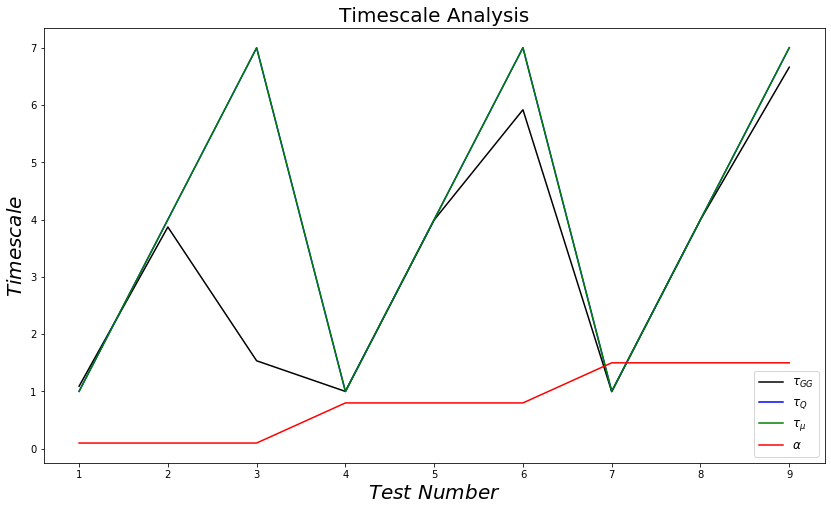

In [199]:
figure44 = plt.figure(figsize = (14,8))
plt.title(r"Timescale Analysis", fontsize = 20)

taus_MU = np.tile(tau_MU_vector, number_of_points)
alphas = np.repeat(alpha_vector, 3)

plt.plot(np.arange(1,number_of_points*number_of_points+1), taus_GG,  color = 'k', label = r"$\tau_{GG}$")
plt.plot(np.arange(1,number_of_points*number_of_points+1), taus_Q,  color = 'b', label = r"$\tau_{Q}$")
plt.plot(np.arange(1,number_of_points*number_of_points+1), taus_MU,  color = 'g', label = r"$\tau_{\mu}$" )
plt.plot(np.arange(1,number_of_points*number_of_points+1), alphas,  color = 'r', label = r"$\alpha$" )


plt.xlabel(r"$Test \ Number$", fontsize = 20)
plt.ylabel(r"$Timescale$", fontsize = 20)
plt.legend(loc = 4, prop={'size': 12})
#plt.yscale('log')
plt.show()

**Is $\tau_{NT} = \tau_{\mu}$ for large lags ?** 

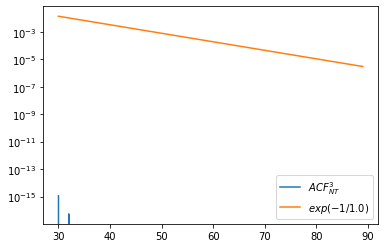

In [204]:
i = 3
plt.plot(np.arange(30,90), -1*ACFs_NT[i][30:90], label = r"$ACF_{{NT}}^{}$".format(i))
plt.plot(np.arange(30,90), np.exp(-np.arange(0,100)/7)[30:90], label = r"$exp(-1/{})$".format(taus_MU[i]))
plt.yscale('log')
plt.legend()

**Fitting multiple Gs as $\delta_{0} + exp$**

In [205]:
parameters_G = []
from scipy.optimize import curve_fit

def delta_exp(x_G, a, tau, delta_amplitude):
    return a*np.exp(-x_G/tau) + delta_amplitude*delta_vector(len(x_G))


for i in range(0, number_of_points*number_of_points):
    y_G = Gs[i][0,0:100]
    x_G = np.arange(0,100)
    parameters, cov = curve_fit(f = delta_exp, xdata = x_G, ydata = y_G, p0 = [1,taus_MU[i],1])
    parameters_G.append(parameters)

**Is $\tau_{G} = \tau{\mu}$ ?**

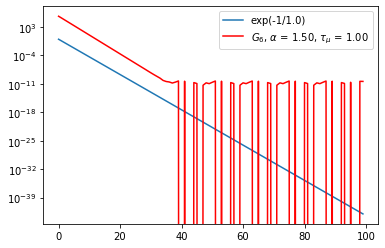

In [216]:
colors_vector = ['b', 'g', 'r','c', 'm', 'k', 'y', 'lime', 'indigo'] 

i = 6
plt.plot(np.arange(0,100), np.exp(-1*np.arange(0,100)/taus_MU[i]), label = f"exp(-1/{taus_MU[i]})")
plt.plot(np.arange(0,100), 10000000*Gs[i][0,0:100], label = r"$G_{}$, $\alpha$ = {:.2f}, $\tau_{{\mu}}$ = {:.2f} ".format(i, alphas[i], taus_MU[i]), color = colors_vector[j])
plt.legend()
plt.yscale('log')

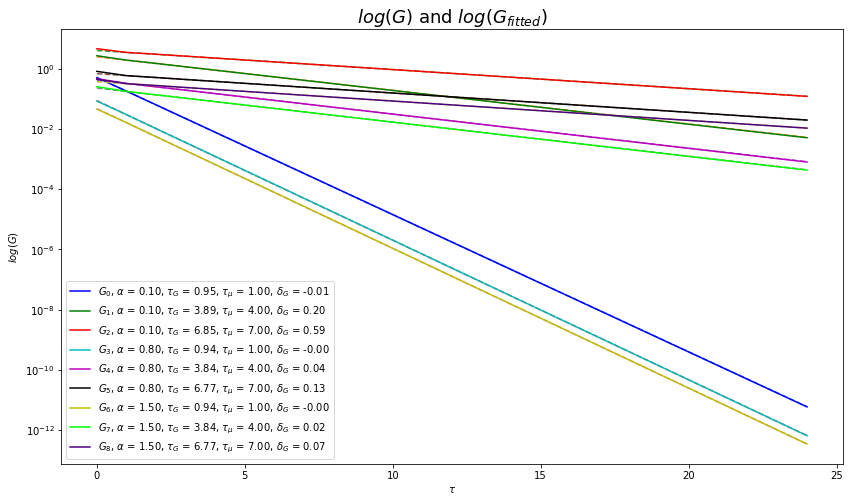

In [217]:
figure41 = plt.figure(figsize = (14,8))
plt.title(r"$log(G)$ and $log(G_{fitted})$", fontsize = 18)

colors_vector = ['b', 'g', 'r','c', 'm', 'k', 'y', 'lime', 'indigo'] 


for i in range(0, number_of_points*number_of_points):
    plt.plot(np.arange(0,25), parameters_G[i][0]*np.exp(-1*np.arange(0,25)/parameters_G[i][1]), linestyle = "dashed")
    plt.plot(np.arange(0,25), Gs[i][0,0:25], label = r"$G_{}$, $\alpha$ = {:.2f}, $\tau_{{G}}$ = {:.2f}, $\tau_{{\mu}}$ = {:.2f}, $\delta_{{G}}$ = {:.2f}".format(i, alphas[i], parameters_G[i][1], taus_MU[i], parameters_G[i][2]), color = colors_vector[i])
plt.xlabel(r"$\tau$")
plt.ylabel(r"$log(G)$")
plt.legend()
plt.yscale('log')

**Investigating the behavior of $G^{-1}$**

In [218]:
G_invs = []
for i in range(0, number_of_points*number_of_points):
    G_invs.append(np.linalg.inv(Gs[i]))

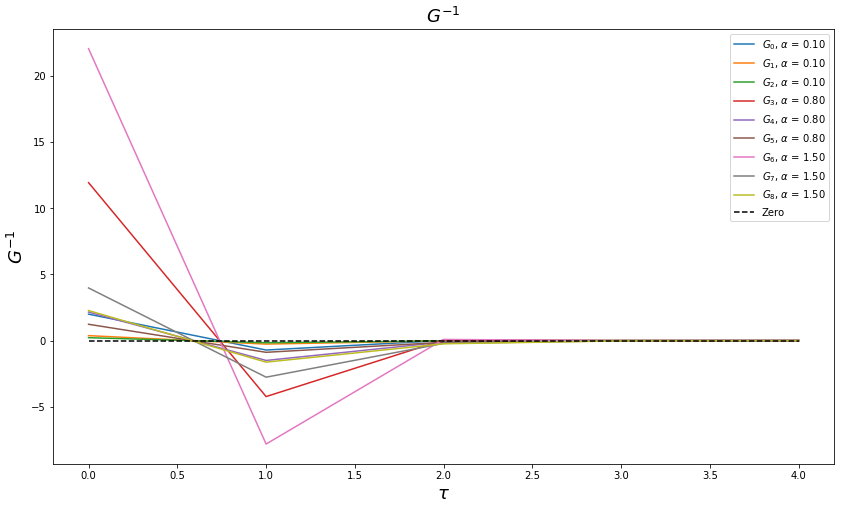

In [219]:
figure41 = plt.figure(figsize = (14,8))

plt.title(r"$G^{-1}$", fontsize = 18)
for i in range(0, number_of_points*number_of_points):
    plt.plot(np.arange(0,5), G_invs[i][0,0:5], label = r"$G_{}$, $\alpha$ = {:.2f}".format(i, alphas[i]))
plt.plot(np.arange(0,5), np.zeros(5), color='k', linestyle='dashed', label = "Zero")

plt.xlabel(r"$\tau$", fontsize = 18)
plt.ylabel(r"$G^{-1}$", fontsize = 18)
plt.legend()

## Exploring properties in function of the Discouting Factor - $\tau$

In [35]:
T = 100
T_it = 100
G_0_seed = 1
alpha_G = 0.5
seed_type = "mark"
C_NT_0 = 1
tau_NT = 1
C_IT_0 = 1
tau_IT = 1
tau = 5
bound_for_convergence = 0.00001


Var_TGT = 1
ACF_TGT = Var_TGT*np.identity(T) ## Var_tgt is a white noise process

I = np.identity(T)

tau_MU = 5

alpha = 1

tau_min = 1
tau_max = 8

number_of_points = 16

tau_vector = np.linspace(tau_min, tau_max, number_of_points)

cte = np.exp(-1/tau_MU)
C_MU_0 = ((1 - cte)/(cte))**2

D_MUs = []
D_TGTs = []
D_MU_NTs = []
D_TGT_NTs = []
D_MU_ITs = []
D_TGT_ITs = []
ACFs_NT = []
ACFs_Q = []
Gs = []
ACFs_MU = []
ACFs_IT = []
ACFs_P = []

In [36]:
for i in range(0, number_of_points):
    
        numerical_solution = numerical_solver_simulation(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type, C_NT_0, 
                            tau_NT, C_IT_0, tau_IT, tau_vector[i], _ , bound_for_convergence)

        D_MU = numerical_solution[3][-1][0]
        D_TGT =  numerical_solution[3][-1][1]
        D_MU_NT =  numerical_solution[3][-1][2]
        D_TGT_NT =  numerical_solution[3][-1][3] 
        D_MU_IT =  numerical_solution[3][-1][4]
        D_TGT_IT =  numerical_solution[3][-1][5]
    
        D_MUs.append(D_MU)
        D_TGTs.append(D_TGT)
        D_MU_NTs.append(D_MU_NT)
        D_TGT_NTs.append(D_TGT_NT)
        D_MU_ITs.append(D_MU_IT)
        D_TGT_ITs.append(D_TGT_IT)
        ACFs_NT.append(numerical_solution[4][-1][0,:])
        ACFs_Q.append(numerical_solution[6][-1][0,:])
        ACFs_IT.append(numerical_solution[5][-1][0,:])
        ACFs_P.append(numerical_solution[8][0,:])
        Gs.append(numerical_solution[2][-1])
    
        print(f"Finished test {i + 1}")

Finished test 1
Finished test 2
Finished test 3
Finished test 4
Finished test 5
Finished test 6
Finished test 7
Finished test 8
Finished test 9
Finished test 10
Finished test 11
Finished test 12
Finished test 13
Finished test 14
Finished test 15
Finished test 16


## Plotting Informational Market Efficiency vs $\tau$

Text(0.5, 1.0, 'Informational Market Efficiency')

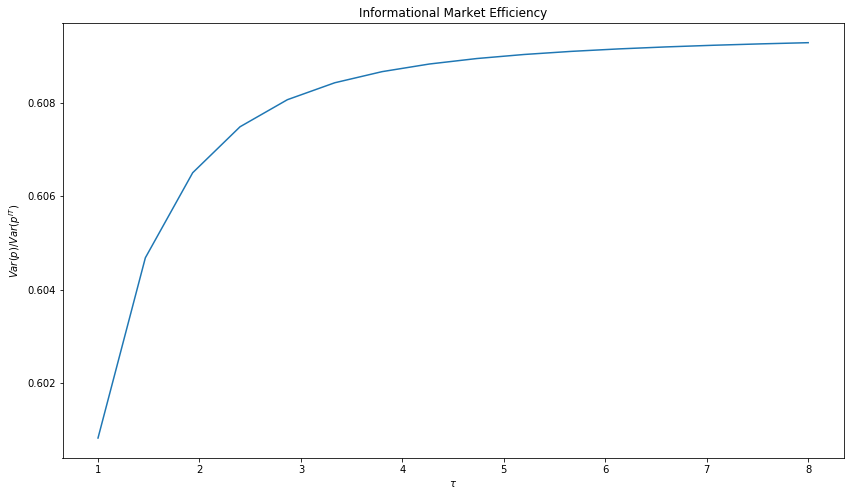

In [48]:
figure41 = plt.figure(figsize = (14,8))

informational_market_efficiency_for_different_tau = []

for i in range(0, number_of_points):
      informational_market_efficiency_for_different_tau.append(ACFs_P[i][0])
        
plt.plot(tau_vector, informational_market_efficiency_for_different_tau)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$Var(p)/Var(p^{IT})$")
plt.title("Informational Market Efficiency")

## Plotting IT's Order Flow Variance vs $\tau$


Text(0.5, 1.0, "IT's Order Flow Variance vs Discounting Factor")

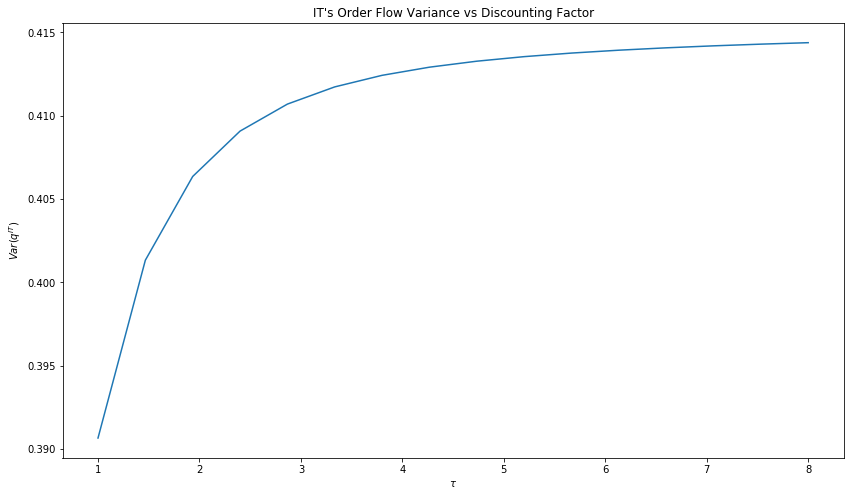

In [54]:
figure41 = plt.figure(figsize = (14,8))

IT_order_flow_variance = []

for i in range(0, number_of_points):
      IT_order_flow_variance.append(ACFs_IT[i][0])
        
plt.plot(tau_vector, IT_order_flow_variance)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$Var(q^{IT})$")
plt.title("IT's Order Flow Variance vs Discounting Factor")

## Plotting NT's Order Flow Variance vs $\tau$


Text(0.5, 1.0, "NT's Order Flow Variance vs Discounting Factor")

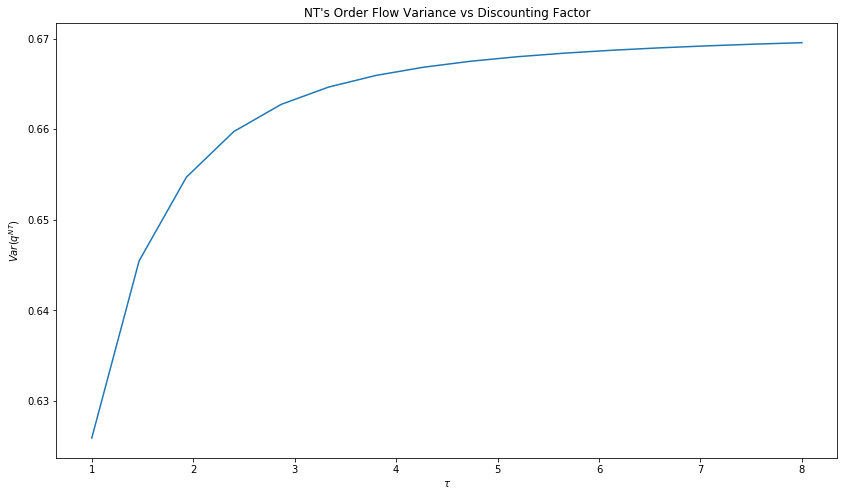

In [53]:
figure41 = plt.figure(figsize = (14,8))

NT_order_flow_variance = []

for i in range(0, number_of_points):
      NT_order_flow_variance.append(ACFs_NT[i][0])
        
plt.plot(tau_vector, NT_order_flow_variance)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$Var(q^{NT})$")
plt.title("NT's Order Flow Variance vs Discounting Factor")

## Plotting Total Order Flow Variance vs $\tau$

Text(0.5, 1.0, 'Total Order Flow Variance vs Discounting Factor')

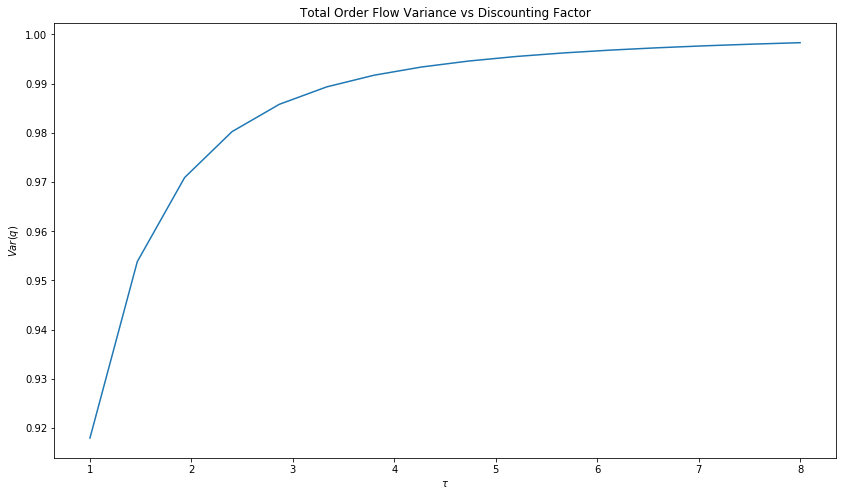

In [57]:
figure41 = plt.figure(figsize = (14,8))

total_order_flow_variance = []

for i in range(0, number_of_points):
      total_order_flow_variance.append(ACFs_Q[i][0])
        
plt.plot(tau_vector,total_order_flow_variance)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$Var(q)$")
plt.title("Total Order Flow Variance vs Discounting Factor")